<div style="text-align: right">INFO 6106 Neural Modeling, Final Project, Milestone 1</div>
<div style="text-align: right">Lokeshwaran Balamurugan, Nitin Sai Varma Indukuri, Krishica Gopalakrishnan</div>

# Final Project: Milestone 1: Part 2
<div style="text-align: center;">
    <img src="images/A_visually_appealing_digital_illustration_represen.jpg" width="400" />
</div>

## Objective
Preprocessing + Target Creation + Sliding Window Notebook: ( 30 marks )  
- <b>Data Cleaning:</b>
    - You have to check for and handle missing values
    - You have to drop irrelevant or redundant features etc
- <b>Filter Data</b>:
    - You can check which data is needed and which can be dropped ( Example day time data and their UTC times ) 
    - Combine columns if needed
    - Resize satellite images to 64x64 resolution using OpenCV.
- <b>Create Target Variable:</b>
    - Define precipitation thresholds to classify records into four categories:
        - No Rain: precipitation == 0
        - Less Rain: 0 < precipitation <= X1
        - Medium Rain: X1 < precipitation <= X2
        - High Rain: precipitation > X2
    - Add a new column precipitation_category with the above classifications.
- <b>Sliding Window Implementation</b>:
    Create sliding windows for the input:
    - Use 24-hour meteorological data as input for predicting the next day’s precipitation category.
    - Use 48-hour meteorological data as input for predicting the next-to-next day’s precipitation category.
    - Use 72-hour meteorological data as input for predicting the next-to-next day’s precipitation category

   

## 1. Import Libraries
Import essential libraries for data manipulation, visualization, image processing, and utility functions.

In [2]:
# Data Manipulation Libraries
import os
import pandas as pd
import numpy as np
import pickle
import ast

# Plotting Libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

# Image Processing Libraries
from PIL import Image, ImageOps
import cv2

from imblearn.over_sampling import SMOTE

# Utility Libraries
from tqdm import tqdm

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

## 2. Load Dataset
Read the meteorological dataset.

In [3]:
# Define the path to the CSV file
csv_file = 'test/2006Fall_2017Spring_GOES_meteo_combined.csv'

# Load the dataset
les = pd.read_csv(csv_file)

# Display the first few rows
print("Initial DataFrame Head:")
display(les.head())

Initial DataFrame Head:


,Date_UTC,Time_UTC,Date_CST,Time_CST,File_name_for_1D_lake,File_name_for_2D_lake,Lake_data_1D,Lake_data_2D,Temp (F),RH (%),...,Low Cloud Ht (ft),Med Cloud Ht (ft),High Cloud Ht (ft),Visibility (mi),Atm Press (hPa),Sea Lev Press (hPa),Altimeter (hPa),Precip (in),Wind Chill (F),Heat Index (F)
0,2006-10-01,00:00,2006-09-30,00:00,goes11.2006.10.01.0000.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0000.v01.nc-var1-t0.csv.csv,"[0.0075, 0.0025, 0.0, 0.005, 0.0, 0.005, nan, ...","[array([ nan, nan, nan, nan, nan...",48,86,...,4100,4800,7000,10,984.0,1007.00,1006.80,0.00,45,NC
1,2006-10-01,01:00,2006-09-30,01:00,goes11.2006.10.01.0100.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0100.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0025, 0.0025, nan, 0.0, nan, 0...","[array([ nan, nan, nan, nan, nan...",48,86,...,6000,m,m,10,983.7,1006.50,1006.40,0.00,44,NC
2,2006-10-01,02:00,2006-09-30,02:00,goes11.2006.10.01.0200.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0200.v01.nc-var1-t0.csv.csv,"[0.0, nan, 0.0075, nan, nan, 0.0025, nan, nan,...","[array([nan, nan, nan, nan, nan, nan, nan, nan...",48,86,...,5500,11000,m,10,982.7,1005.70,1005.40,0.00,45,NC
3,2006-10-01,03:00,2006-09-30,03:00,goes11.2006.10.01.0300.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0300.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0025, 0.0, 0.0075, nan, 0.005,...","[array([nan, nan, nan, nan, nan, nan, nan, nan...",48,86,...,6000,m,m,10,982.0,1005.10,1004.70,0.00,44,NC
4,2006-10-01,04:00,2006-09-30,04:00,goes11.2006.10.01.0400.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0400.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0, nan, 0.0075, 0.0, nan, nan,...","[array([ nan, nan, nan, nan, nan...",48,89,...,2200,3500,m,8,982.0,1004.90,1004.70,0.02,46,NC


In [4]:
# Display column names
column_names = les.columns.tolist()
print("\nColumn Names:")
print(column_names)


Column Names:
['Date_UTC', 'Time_UTC', 'Date_CST', 'Time_CST', 'File_name_for_1D_lake', 'File_name_for_2D_lake', 'Lake_data_1D', 'Lake_data_2D', 'Temp (F)', 'RH (%)', 'Dewpt (F)', 'Wind Spd (mph)', 'Wind Direction (deg)', 'Peak Wind Gust(mph)', 'Low Cloud Ht (ft)', 'Med Cloud Ht (ft)', 'High Cloud Ht (ft)', 'Visibility (mi)', 'Atm Press (hPa)', 'Sea Lev Press (hPa)', 'Altimeter (hPa)', 'Precip (in)', 'Wind Chill (F)', 'Heat Index (F)']


## 3. Data Cleaning
<div style="text-align: center;">
    <img src="images/DALL·E 2024-12-02 18.02.01 - A creative digital illustration symbolizing data cleaning with a cloudy theme. The image includes abstract visuals of a data table with cloud elements.webp" width="300" />
</div>

- Renaming Columns
- Replacing Placeholder Values
- Handling Missing Values
- Data Type Conversion

### 3.1 Renaming Columns

We rename variables in a dataset to improve readability and ensure consistency, making it easier for us to understand and work with the data. For instance, when we rename <b>Temp (F)</b> to <b>Temp_F</b>, we eliminate spaces and special characters that might cause coding issues. Similarly, changing <b>RH (%)</b> to <b>RH_pct</b> clarifies the unit while maintaining simplicity. By renaming variables like <b>Wind Spd (mph)</b> to <b>Wind_Spd_mph</b>, we make the dataset self-explanatory, which streamlines our analysis and collaboration efforts.


In [5]:
# Renaming columns for better readability
les.rename(columns={
    "Temp (F)": "Temp_F",
    "RH (%)": "RH_pct",
    "Dewpt (F)": "Dewpt_F",
    "Wind Spd (mph)": "Wind_Spd_mph",
    "Wind Direction (deg)": "Wind_Direction_deg",
    "Peak Wind Gust(mph)": "Peak_Wind_Gust_mph",
    "Low Cloud Ht (ft)": "Low_Cloud_Ht_ft",
    "Med Cloud Ht (ft)": "Med_Cloud_Ht_ft",
    "High Cloud Ht (ft)": "High_Cloud_Ht_ft",
    "Visibility (mi)": "Visibility_mi",
    "Atm Press (hPa)": "Atm_Press_hPa",
    "Sea Lev Press (hPa)": "Sea_Lev_Press_hPa",
    "Altimeter (hPa)": "Altimeter_hPa",
    "Precip (in)": "Precip_in",
    "Wind Chill (F)": "Wind_Chill_F",
    "Heat Index (F)": "Heat_Index_F",
}, inplace=True)

# Display the renamed columns
print("\nDataFrame Head After Renaming:")
display(les.head())


DataFrame Head After Renaming:


,Date_UTC,Time_UTC,Date_CST,Time_CST,File_name_for_1D_lake,File_name_for_2D_lake,Lake_data_1D,Lake_data_2D,Temp_F,RH_pct,...,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in,Wind_Chill_F,Heat_Index_F
0,2006-10-01,00:00,2006-09-30,00:00,goes11.2006.10.01.0000.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0000.v01.nc-var1-t0.csv.csv,"[0.0075, 0.0025, 0.0, 0.005, 0.0, 0.005, nan, ...","[array([ nan, nan, nan, nan, nan...",48,86,...,4100,4800,7000,10,984.0,1007.00,1006.80,0.00,45,NC
1,2006-10-01,01:00,2006-09-30,01:00,goes11.2006.10.01.0100.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0100.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0025, 0.0025, nan, 0.0, nan, 0...","[array([ nan, nan, nan, nan, nan...",48,86,...,6000,m,m,10,983.7,1006.50,1006.40,0.00,44,NC
2,2006-10-01,02:00,2006-09-30,02:00,goes11.2006.10.01.0200.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0200.v01.nc-var1-t0.csv.csv,"[0.0, nan, 0.0075, nan, nan, 0.0025, nan, nan,...","[array([nan, nan, nan, nan, nan, nan, nan, nan...",48,86,...,5500,11000,m,10,982.7,1005.70,1005.40,0.00,45,NC
3,2006-10-01,03:00,2006-09-30,03:00,goes11.2006.10.01.0300.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0300.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0025, 0.0, 0.0075, nan, 0.005,...","[array([nan, nan, nan, nan, nan, nan, nan, nan...",48,86,...,6000,m,m,10,982.0,1005.10,1004.70,0.00,44,NC
4,2006-10-01,04:00,2006-09-30,04:00,goes11.2006.10.01.0400.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0400.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0, nan, 0.0075, 0.0, nan, nan,...","[array([ nan, nan, nan, nan, nan...",48,89,...,2200,3500,m,8,982.0,1004.90,1004.70,0.02,46,NC


### 3.2 Replacing Placeholder values

We perform these operations to clean and prepare our dataset for analysis. By replacing 'm' and 'M' with '0', we ensure data consistency and address non-numeric placeholders in columns like 'File_name_for_1D_lake' and 'File_name_for_2D_lake'. Dropping columns such as 'Wind_Chill_F' and 'Heat_Index_F' removes irrelevant or highly inconsistent data (e.g., many 'NC' values). Resetting the index after dropping rows maintains the dataset's integrity. Finally, displaying missing values using the missing_values function helps us assess the data's quality and identify areas needing further cleaning.


In [6]:
# Check before replacing 'm' and 'M'
print(les[['File_name_for_1D_lake', 'File_name_for_2D_lake']].isna().sum())

# Check after dropping columns
print(les.info())

# Replace 'm' and 'M' with '0' in relevant columns
les = les.replace(['m', 'M'], '0')

print(les[['File_name_for_1D_lake', 'File_name_for_2D_lake']].isna().sum())

# Drop Wind_Chill_F and Heat_Index_F due to a large number of 'NC' values
les = les.drop(['Wind_Chill_F', 'Heat_Index_F'], axis=1)

# Reset the index after dropping rows
les = les.reset_index(drop=True)

# Function to display missing values
def missing_values(df):
    total_null = df.isna().sum()
    percent_null = total_null / len(df)
    missing_data = pd.concat([total_null, percent_null], axis=1, keys=['Total Null', 'Percentage Null'])
    return missing_data

# Display missing values before dropping
print("\nMissing Values Before Dropping:")
print(missing_values(les))

File_name_for_1D_lake    0
File_name_for_2D_lake    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48121 entries, 0 to 48120
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Date_UTC               48121 non-null  object
 1   Time_UTC               48121 non-null  object
 2   Date_CST               48121 non-null  object
 3   Time_CST               48121 non-null  object
 4   File_name_for_1D_lake  48121 non-null  object
 5   File_name_for_2D_lake  48121 non-null  object
 6   Lake_data_1D           48121 non-null  object
 7   Lake_data_2D           48121 non-null  object
 8   Temp_F                 47882 non-null  object
 9   RH_pct                 47882 non-null  object
 10  Dewpt_F                47882 non-null  object
 11  Wind_Spd_mph           47882 non-null  object
 12  Wind_Direction_deg     47882 non-null  object
 13  Peak_Wind_Gust_mph     47882 non-null  object
 14  Low

### 3.3 Handling Missing Values

We drop all rows with any NaN values to ensure that our dataset is free from missing data, which could otherwise cause issues in analysis or modeling. This step reduces inconsistencies and guarantees that all remaining observations are complete.

In [7]:
# Drop all rows with any NaN values
les = les.dropna()
print('Total observation count after missing value treatment: ', len(les))

# Display missing values after dropping
print("\nMissing Values After Dropping:")
print(missing_values(les))

Total observation count after missing value treatment:  47882

Missing Values After Dropping:
                       Total Null  Percentage Null
Date_UTC                        0              0.0
Time_UTC                        0              0.0
Date_CST                        0              0.0
Time_CST                        0              0.0
File_name_for_1D_lake           0              0.0
File_name_for_2D_lake           0              0.0
Lake_data_1D                    0              0.0
Lake_data_2D                    0              0.0
Temp_F                          0              0.0
RH_pct                          0              0.0
Dewpt_F                         0              0.0
Wind_Spd_mph                    0              0.0
Wind_Direction_deg              0              0.0
Peak_Wind_Gust_mph              0              0.0
Low_Cloud_Ht_ft                 0              0.0
Med_Cloud_Ht_ft                 0              0.0
High_Cloud_Ht_ft                0      

### 3.4 Data Type Conversion

We display data types before conversion to understand the current structure and identify columns that need adjustment. By selecting columns (e.g., from 'Temp_F' onwards), we ensure we target relevant numerical data for conversion. Converting these columns to numeric standardizes the dataset, allowing us to handle values efficiently in calculations or modeling. Although we've already dropped NaNs, coercing errors ensures robustness in case of unexpected non-numeric values. Finally, we display data types after conversion to confirm the changes and verify that the dataset is properly prepared for numerical analysis.

In [8]:
# Display data types before conversion
print("\nData Types Before Conversion:")
print(les.info())


Data Types Before Conversion:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 47882 entries, 0 to 48120
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Date_UTC               47882 non-null  object
 1   Time_UTC               47882 non-null  object
 2   Date_CST               47882 non-null  object
 3   Time_CST               47882 non-null  object
 4   File_name_for_1D_lake  47882 non-null  object
 5   File_name_for_2D_lake  47882 non-null  object
 6   Lake_data_1D           47882 non-null  object
 7   Lake_data_2D           47882 non-null  object
 8   Temp_F                 47882 non-null  object
 9   RH_pct                 47882 non-null  object
 10  Dewpt_F                47882 non-null  object
 11  Wind_Spd_mph           47882 non-null  object
 12  Wind_Direction_deg     47882 non-null  object
 13  Peak_Wind_Gust_mph     47882 non-null  object
 14  Low_Cloud_Ht_ft        47882 non-null  

In [9]:
# Identify columns to convert (from 'Temp_F' onwards)
columns_to_convert = les.columns[8:]

# Convert columns to numeric, coercing errors to NaN (though we've already dropped NaNs)
les[columns_to_convert] = les[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Display data types after conversion
print("\nData Types After Conversion:")
print(les.info())


Data Types After Conversion:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 47882 entries, 0 to 48120
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date_UTC               47882 non-null  object 
 1   Time_UTC               47882 non-null  object 
 2   Date_CST               47882 non-null  object 
 3   Time_CST               47882 non-null  object 
 4   File_name_for_1D_lake  47882 non-null  object 
 5   File_name_for_2D_lake  47882 non-null  object 
 6   Lake_data_1D           47882 non-null  object 
 7   Lake_data_2D           47882 non-null  object 
 8   Temp_F                 47882 non-null  float64
 9   RH_pct                 47882 non-null  float64
 10  Dewpt_F                47882 non-null  float64
 11  Wind_Spd_mph           47882 non-null  int64  
 12  Wind_Direction_deg     47882 non-null  int64  
 13  Peak_Wind_Gust_mph     47882 non-null  int64  
 14  Low_Cloud_Ht_ft        4

## 4. Filter Dataset

We filter the dataset to include only observations where 'Time_UTC' is between '14:00' and '21:00', focusing on a specific time range for targeted analysis. After filtering, we reset the index to maintain a clean, sequential structure, which helps with data exploration and further processing. By checking the dataset's shape, we confirm the total number of observations and features remaining, ensuring that our filtering aligns with the analysis requirements while retaining the necessary structure.

In [10]:
# Filter data for Time_UTC between '14:00' and '21:00' (2 PM to 9 PM UTC)
filtered_les = les.loc[(les['Time_UTC'] >= '14:00') & (les['Time_UTC'] <= '21:00')]

# Reset index after filtering
filtered_les = filtered_les.reset_index(drop=True)

# Information about dataset shape
print('\nTotal observations after filtering for Time_UTC between 14:00 and 21:00:', filtered_les.shape[0])
print('Total number of features:', filtered_les.shape[1])


Total observations after filtering for Time_UTC between 14:00 and 21:00: 15959
Total number of features: 22


In [11]:
# Display the filtered DataFrame head
print("\nFiltered DataFrame Head:")
display(filtered_les.head())


Filtered DataFrame Head:


,Date_UTC,Time_UTC,Date_CST,Time_CST,File_name_for_1D_lake,File_name_for_2D_lake,Lake_data_1D,Lake_data_2D,Temp_F,RH_pct,...,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,2006-10-01,14:00,2006-10-01,14:00,goes11.2006.10.01.1400.v01.nc-var1-t0.csv,T_goes11.2006.10.01.1400.v01.nc-var1-t0.csv.csv,"[0.067499995, 0.07, 0.0625, 0.06, 0.0725, 0.06...","[array([ nan, nan, nan, ...",60.0,49.0,...,270,0,3600,0,0,10,994.7,1017.8,1017.6,0.0
1,2006-10-01,15:00,2006-10-01,15:00,goes11.2006.10.01.1500.v01.nc-var1-t0.csv,T_goes11.2006.10.01.1500.v01.nc-var1-t0.csv.csv,"[0.067499995, 0.067499995, 0.06, 0.06, 0.05749...","[array([ nan, nan, nan, ...",60.0,47.0,...,0,0,0,0,0,10,994.7,1017.7,1017.6,0.0
2,2006-10-01,16:00,2006-10-01,16:00,goes11.2006.10.01.1600.v01.nc-var1-t0.csv,T_goes11.2006.10.01.1600.v01.nc-var1-t0.csv.csv,"[0.0725, 0.067499995, 0.07, 0.07, 0.067499995,...","[array([ nan, nan, nan, nan, nan...",59.0,55.0,...,40,0,0,0,0,10,994.7,1017.8,1017.6,0.0
3,2006-10-01,17:00,2006-10-01,17:00,goes11.2006.10.01.1700.v01.nc-var1-t0.csv,T_goes11.2006.10.01.1700.v01.nc-var1-t0.csv.csv,"[0.067499995, 0.067499995, 0.067499995, 0.07, ...","[array([ nan, nan, nan, nan, nan, nan, n...",55.0,71.0,...,0,0,0,0,0,10,994.7,1017.8,1017.6,0.0
4,2006-10-01,18:00,2006-10-01,18:00,goes11.2006.10.01.1800.v01.nc-var1-t0.csv,T_goes11.2006.10.01.1800.v01.nc-var1-t0.csv.csv,"[0.085, 0.085, 0.0875, 0.0725, 0.0775, 0.0775,...","[array([ nan, nan, nan, nan, nan...",50.0,82.0,...,0,0,8000,0,0,10,994.7,1017.9,1017.6,0.0


In [12]:
# Summary statistics of the filtered data
print("\nSummary Statistics:")
display(filtered_les.describe())


Summary Statistics:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
count,15959.000000,15959.000000,15959.000000,15959.000000,15959.000000,15959.000000,15959.000000,15959.000000,15959.000000,15959.000000,15959.000000,15959.000000,15959.000000,15959.000000
mean,34.931261,68.740335,25.234351,7.137039,158.714832,4.500971,4563.800363,3457.098816,1033.362993,8.174698,990.931687,960.019663,1014.892355,0.002377
std,14.344283,14.927241,13.538403,5.093937,128.081797,9.510925,5747.505620,6318.061684,3981.234855,3.033164,41.719389,232.924553,26.926521,0.016545
min,-15.000000,0.000000,-20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,59.000000,16.000000,3.000000,0.000000,0.000000,1500.000000,0.000000,0.000000,7.000000,987.000000,1009.500000,1009.800000,0.000000
50%,34.000000,70.000000,25.000000,7.000000,190.000000,0.000000,2700.000000,0.000000,0.000000,10.000000,993.300000,1016.400000,1016.300000,0.000000
75%,44.000000,80.000000,34.000000,10.000000,270.000000,0.000000,4500.000000,4000.000000,0.000000,10.000000,999.000000,1022.500000,1022.000000,0.000000
max,88.000000,100.000000,66.000000,34.000000,360.000000,52.000000,28000.000000,25000.000000,26000.000000,10.000000,1018.900000,1043.600000,1042.300000,0.860000


## 5. Load Latitude and Longitude Data
Load the latitude and longitude coordinates from a separate CSV file to process cloud cover data.

In [13]:
# Define the path to the latitude and longitude CSV file
lat_lon_file = 'lat_long_1D_labels_for_plotting.csv'  # Update the path if necessary

# Load latitude and longitude data
df_lat_lon = pd.read_csv(lat_lon_file)

# Extract latitude and longitude lists
lat_lst = df_lat_lon['latitude'].tolist()
lon_lst = df_lat_lon['longitude'].tolist()

# Verify that the number of latitude and longitude points matches the number of cloud data points
assert len(lat_lst) == len(lon_lst), "Latitude and Longitude lists must be of the same length."

print(f'Number of geographical points: {len(lat_lst)}')

Number of geographical points: 3599


## 6. Generate Satellite Cloud Images

<div style="text-align: center;">
    <img src="images/DALL·E 2024-12-02 18.03.39 - A realistic and visually striking digital illustration of a GOES (Geostationary Operational Environmental Satellite) in space. The satellite is shown .webp" width="250" />

We'll convert 1D cloud cover data into grayscale images representing the cloud distribution. And, we'll do this by processing and visualizing cloud data by following these steps:

<b>Handling Missing Data</b>
- We will use the rectify function to clean the cloud sequence data. This function will replace any 'NaN' values with 0.0 and convert the remaining values into a numerical list, ensuring our data is ready for visualization.

In [14]:
# Function to handle missing data in cloud sequences
def rectify(crap_string):
    return [0.0 if el.lower() == 'nan' else float(el) for el in crap_string.strip('][').split(', ')]

<b>Setting up dictionaries</b>
- We will create directories for saving the images (lake-michigan-images/original-full).

In [15]:
# Define directories for saving images
original_images_dir = 'lake-michigan-images/original-full'

# Create directories if they don't exist
os.makedirs(original_images_dir, exist_ok=True)

print("Image directories are set up.")

Image directories are set up.


<b>Create a Visualization Function</b>
- Next, we will use the arrays_2_png function to generate grayscale scatter plots from the latitude, longitude, and cloud data values (lat, lon, val).

In [16]:
# Function to convert 1D cloud data to PNG image
def arrays_2_png(lat, lon, val, fig_name, save_path=original_images_dir):
    status_code = -1
    # Ensure lat, lon, and val have the same length
    if len(lat) == len(lon) == len(val):
        plt.figure(figsize=(10, 10))
        plt.scatter(lon, lat, c=val, cmap=cm.gray, marker='s')
        plt.axis('off')  # Remove axes for clean images
        plt.savefig(os.path.join(save_path, f'{fig_name}.png'), bbox_inches='tight', pad_inches=0)
        plt.close()
        status_code = 0
    else:
        status_code = 255
    return status_code

<b>Generating Images</b>
- We will iterate over each record in our filtered dataset (filtered_les), generating images for the Lake_data_1D column. Before creating an image, we will check if it already exists to avoid unnecessary work. If it doesn’t exist, we will process the data and save the corresponding PNG image.

In [17]:
# Iterate over the filtered DataFrame to generate images
print("\nGenerating images for records within 14:00 to 21:00 UTC...")

for i, row in tqdm(filtered_les.iterrows(), total=filtered_les.shape[0]):
    img_filename = os.path.join(original_images_dir, f'{i}.png')
    if not os.path.exists(img_filename):
        try:
            arr = rectify(row['Lake_data_1D'])
            arrays_2_png(lat_lst, lon_lst, arr, str(i))
        except Exception as e:
            print(f"Error at row {i}: {e}")
    else:
        continue  # Skip if the image already exists

  0%|          | 0/15959 [00:00<?, ?it/s]


Generating images for records within 14:00 to 21:00 UTC...


100%|██████████| 15959/15959 [00:03<00:00, 4984.79it/s]


### 6.1 Visualizing a sample Image
Now, why don't we make sure that the data is processed correctly before we move on? Let's do visualize a sample cloud image to ensure the data is correctly processed.

Let's take it step-by-step:

<b>1. Loading the Image</b>

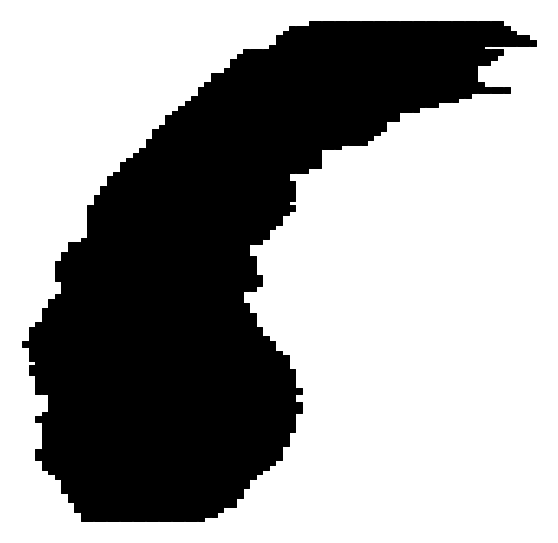

In [18]:
img = Image.open('lake-michigan-images/original-full/39.png')
img

<b>2. Apply Masking:</b>

Let us mask the cloud data to ensure proper delineation of the region of interest.

In [19]:
#full = np.full(img.size, 255)
img = ImageOps.grayscale(img)
#mask = (full - img).astype(np.uint8)
#mask = (0 < mask).astype(int)
img = np.asarray(img)
mask = (255 != img).astype(int)
np.nonzero(mask)

(array([ 21,  21,  21, ..., 521, 521, 521], dtype=int64),
 array([309, 310, 311, ..., 202, 203, 204], dtype=int64))

In [20]:
(mask * 255)[21, 309], (mask * 255)[521, 204]

(255, 255)

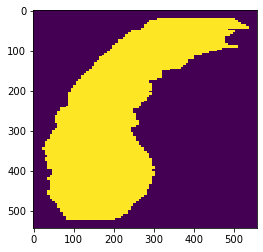

In [21]:
plt.imshow(mask * 255, interpolation='none')
plt.show()

<b>3. Grayscaling </b>

Now that we have prperly masked the image, let us grayscale it.

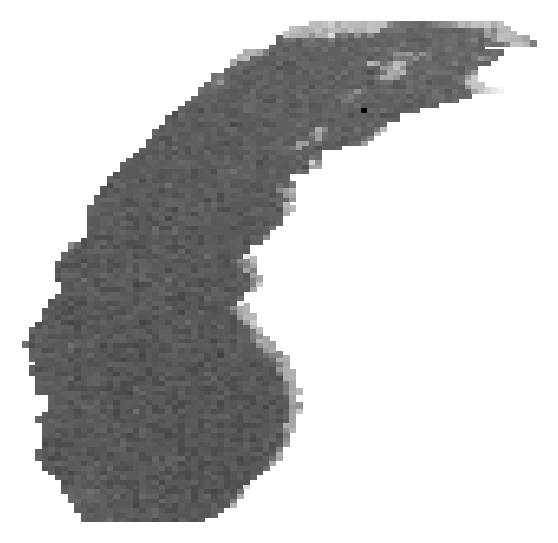

In [22]:
img = Image.open('lake-michigan-images/original-full/6.png')
img = ImageOps.grayscale(img)
img

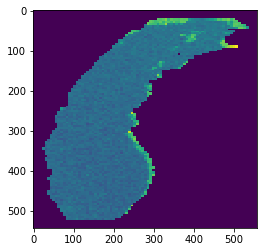

In [23]:
newimg = np.asarray(img) * mask # mask with the lake michigan mask to zero out outside region
plt.imshow(newimg, interpolation='none')
plt.show()

In [24]:
(newimg)[21, 309], (newimg)[521, 204]

(189, 92)

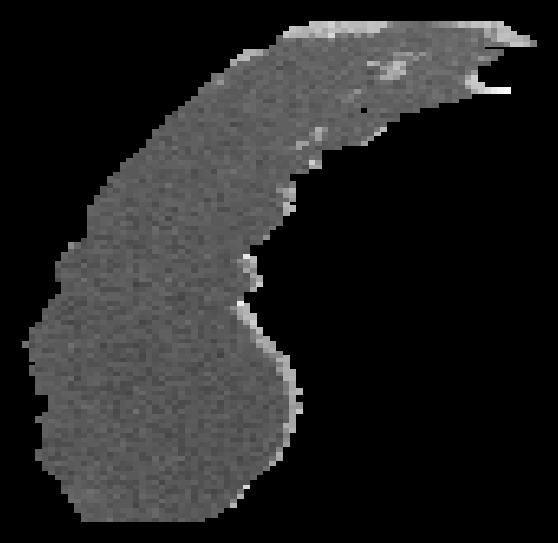

In [25]:
ImageOps.grayscale(Image.fromarray(newimg))

Perfect! As we can see, the data is processed perfectly. We can now move on to further processing.

<div style="text-align: center;">
    <img src="images/BN-OA698_mcmani_P_20160516115635.jpg" width="400" />

## 8. Image Transformation
Let us transform all of our image data into a consistend format, so that our Convolution Model can take these images as inputs.

### 8.1 Resizing and Normalizing Images

We will transform and standardize our images by resizing and applying a mask through the following methods:
- <b>Iterating Through Images:</b>
    We will go through each image in the original dataset. For images that have already been resized, we will skip them to avoid duplicating work.
- <b>Processing Images:</b>
    For the remaining images, we will convert them to grayscale to simplify the data and make them uniform. We will then apply a mask to adjust the pixel values as required. After masking, we will resize each image to a standard size of 64x64 pixels to ensure consistency across the dataset.
- <b>Saving the Transformed Images:</b>
    Once processed, we will save the resized images to a separate location to maintain a clear distinction between original and transformed datasets.

In [26]:
# Directories for source and destination images
source_dir = 'lake-michigan-images/original-full'
dest_dir = 'lake-michigan-images-64-full'

# Create destination directory if it doesn't exist
os.makedirs(dest_dir, exist_ok=True)

# Iterate over the files in the source directory
for file in tqdm(os.listdir(source_dir)):
    source_img_path = os.path.join(source_dir, file)
    dest_img_path = os.path.join(dest_dir, file)

    # Check if the resized image already exists
    if not os.path.exists(dest_img_path):
        try:
            # Open and process the image
            img = Image.open(source_img_path)
            img = ImageOps.grayscale(img)
            newimg = np.asarray(img) * mask  # Apply the mask
            newimg64 = ImageOps.grayscale(Image.fromarray(newimg)).resize((64, 64), Image.LANCZOS)
            newimg64.save(dest_img_path)
        except Exception as e:
            print(f"Error processing {file}: {e}")
            continue  # Skip to the next image
    else:
        continue  # Skip processing if the resized image already exists

100%|██████████| 15959/15959 [00:01<00:00, 8980.95it/s]


### 8.2 Load Processed Images
Now, let's just load all the process images into one NumPy Array, so that we can send it as one input to our model.

In [27]:
from tqdm import tqdm
import cv2

# images = []
# for idx in tqdm(range(15959)):
#     # im shape -> (64, 64)
#     im = cv2.imread('lake-michigan-images-64-full/' + str(idx) + '.png')
#     # Storing 1 channel, since the images are grayscale, and cropping
#     images.append(im[:,:,0]) 
#     # images shape -> (35, 64, 64) 

images = []

for idx in tqdm(range(15959)):
#     if 10127 <= idx <= 13046:
#         continue  # Skip corrupted images
    try:
        img_path = f'lake-michigan-images-64-full/{idx}.png'
        im = cv2.imread(img_path)
        if im is not None:
            # Storing 1 channel, since the images are grayscale
            images.append(im[:, :, 0])
        else:
            print(f"Image at index {idx} is missing or cannot be read.")
    except Exception as e:
        print(f"Error at index {idx}: {e}")

100%|██████████| 15959/15959 [00:08<00:00, 1781.90it/s]


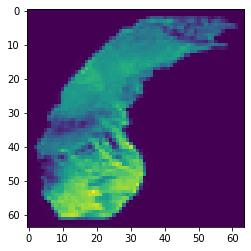

In [28]:
plt.imshow(images[146]) 

In [29]:
print("Data type:", type(images[146]))
print("Shape:", images[146].shape)
print("Data range:", images[146].min(), "to", images[146].max())


Data type: <class 'numpy.ndarray'>
Shape: (64, 64)
Data range: 0 to 247


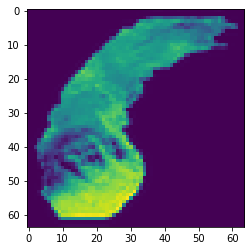

In [30]:
plt.imshow(images[147])

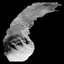

In [31]:
Image.open('lake-michigan-images-64-full/147.png')

Before, we move on to the next step, let us make sure that number of images, is matching the number of filtered records in our data.

In [32]:
# Check that the number of images matches the number of filtered records
assert len(images) == len(filtered_les), "Number of images must match the number of filtered records."

# Add a column for image indices to 'filtered_les' for easy reference
filtered_les['image_index'] = filtered_les.index

### 8.3 Visualize Images for a Specific Date
Let's make sure that we can retrieved data properly, we'll try to display cloud images for a specific date to visually inspect the data.


In [33]:
# Function to visualize images for a specific date
def visualize_images_for_date(df, images_list, date):
    """
    Displays the 8 images for a given date.
    
    Args:
        df (pd.DataFrame): DataFrame containing the records.
        images_list (list): List of image arrays.
        date (str): Date in 'YYYY-MM-DD' format.
    """
    # Filter records for the specified date
    date_records = df[df['Date_UTC'] == date]
    
    if date_records.empty:
        print(f"No records found for date: {date}")
        return
    
    # Retrieve the image indices for this date
    img_indices = date_records['image_index'].tolist()
    
    # Number of images expected (8 hours)
    expected_num_images = 8
    
    if len(img_indices) != expected_num_images:
        print(f"Expected {expected_num_images} images for date {date}, but found {len(img_indices)}.")
    
    # Retrieve the images
    date_images = [images_list[idx] for idx in img_indices]
    
    # Plot the images
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(f'Cloud Images for {date}', fontsize=16)
    
    for i, ax in enumerate(axes.flat):
        if i < len(date_images):
            ax.imshow(date_images[i], cmap='gray')
            hour = date_records.iloc[i]['Time_UTC']
            ax.set_title(f'{hour} UTC')
        else:
            ax.axis('off')  # Hide any unused subplots
        ax.axis('off')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Function to select a random date and visualize its images
def visualize_random_date(df, images_list):
    """
    Selects a random date from the DataFrame and visualizes its images.
    
    Args:
        df (pd.DataFrame): DataFrame containing the records.
        images_list (list): List of image arrays.
    """
    unique_dates = df['Date_UTC'].unique()
    random_date = np.random.choice(unique_dates)
    visualize_images_for_date(df, images_list, random_date)


Visualizing images for a random date:


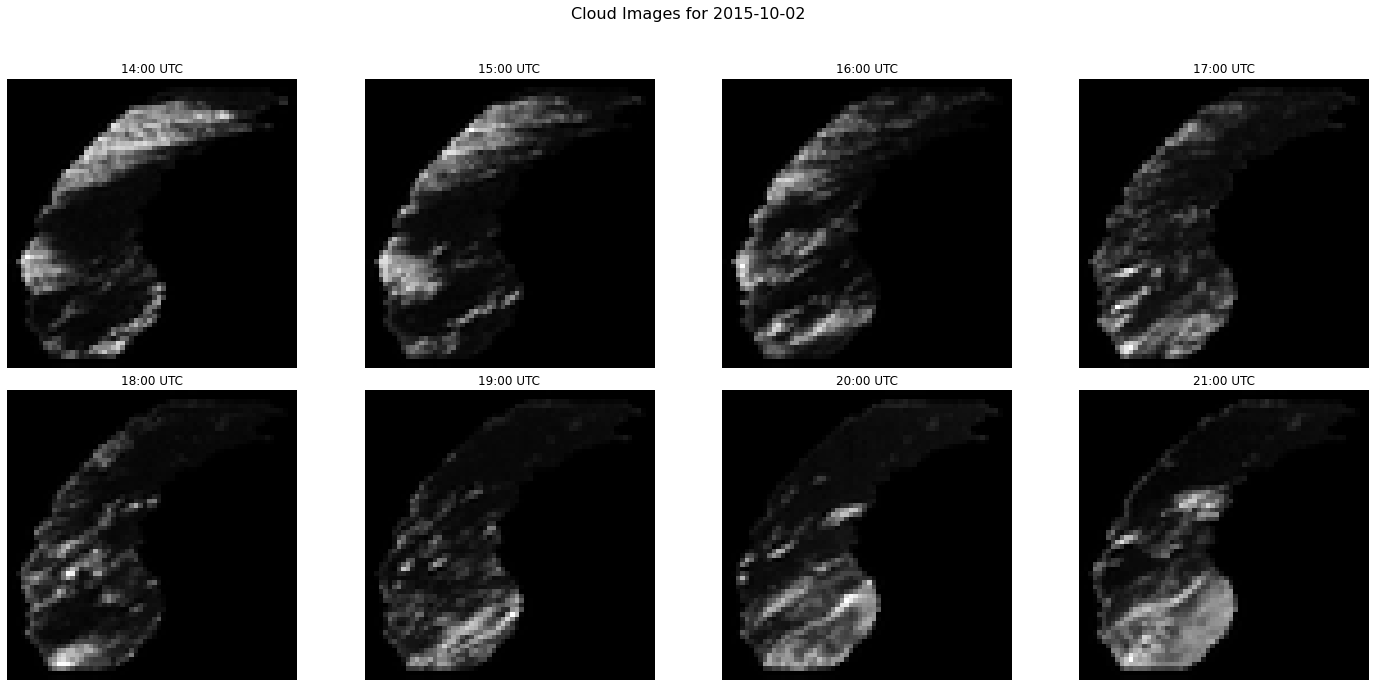

In [34]:
# Example Usage:
print("\nVisualizing images for a random date:")
visualize_random_date(filtered_les, images)

<b>Why do we see `image_index` for only 8 rows in a 24-hour period?</b>

1. The `image_index` column reflects the association between meteorological observations and satellite images.
2. Images are available only for rows in the filtered dataset (`filtered_les`), where `Time_UTC` is between `14:00` and `21:00`.
3. For a 24-hour period, this filter results in 8 rows with valid `image_index` values, one for each hour within the time range.
4. Rows outside this range have `image_index` set to `-1`, indicating that no image exists for those timestamps.
5. This distinction ensures clear handling of both rows with and without images during further processing, such as sliding window creation.


Now, with that out of the way, let's move on.

## 9. Categorize Precipitation
One of the requirements for us to get our model running, is for us to classify the continous precipitation values into categories. 

### 9.1 Understanding the Distribution

In order for us to categorize the continous values of Precipitation in inches, we need to understand the distribution fo the Precipitaton over Lake Michigan, across the entireity of our dataset.

In [35]:
# Summary statistics of 'Precip_in'
print("Summary Statistics for 'Precip_in':")
print(les['Precip_in'].describe())

Summary Statistics for 'Precip_in':
count    47882.000000
mean         0.002226
std          0.015405
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.400000
Name: Precip_in, dtype: float64


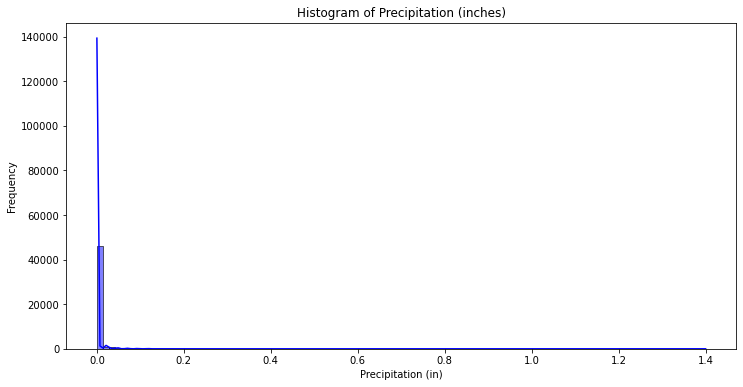

In [36]:
plt.figure(figsize=(12, 6))
sns.histplot(les['Precip_in'], bins=100, kde=True, color='blue')
plt.title('Histogram of Precipitation (inches)')
plt.xlabel('Precipitation (in)')
plt.ylabel('Frequency')
plt.show()

Among the non-zero values, the majority are low, with most being below 0.03 inches, as reflected in both the histogram and quantiles. Higher precipitation values are extremely rare, emphasizing light rainfall as a predominant trend.

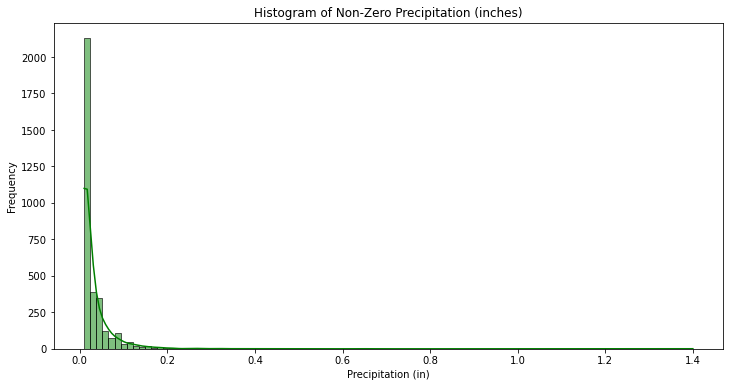

In [37]:
plt.figure(figsize=(12, 6))
sns.histplot(les[les['Precip_in'] > 0]['Precip_in'], bins=100, kde=True, color='green')
plt.title('Histogram of Non-Zero Precipitation (inches)')
plt.xlabel('Precipitation (in)')
plt.ylabel('Frequency')
plt.show()

The majority of precipitation values are concentrated around zero, with very few non-zero precipitation measurements. The histogram for all precipitation values shows a heavy skew toward zero, indicating sparse rainfall events.

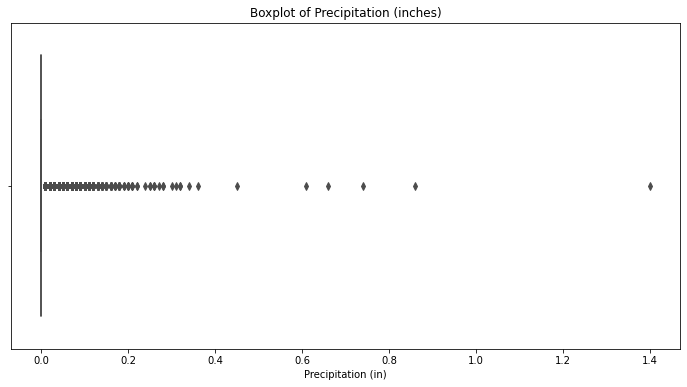

In [38]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=les['Precip_in'], color='orange')
plt.title('Boxplot of Precipitation (inches)')
plt.xlabel('Precipitation (in)')
plt.show()

The boxplot reveals the presence of numerous outliers, with a sharp increase in precipitation values beyond a certain threshold. This indicates occasional heavy rainfall events, though they are outliers in an otherwise light-precipitation dataset.

In [39]:
# Extract non-zero precipitation values
non_zero_precip = les[les['Precip_in'] > 0]['Precip_in']

# Calculate quantiles
quantiles = non_zero_precip.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print("Quantiles of Non-Zero Precipitation:")
print(quantiles)

Quantiles of Non-Zero Precipitation:
0.25    0.0100
0.50    0.0200
0.75    0.0300
0.90    0.0700
0.95    0.1000
0.99    0.1853
Name: Precip_in, dtype: float64


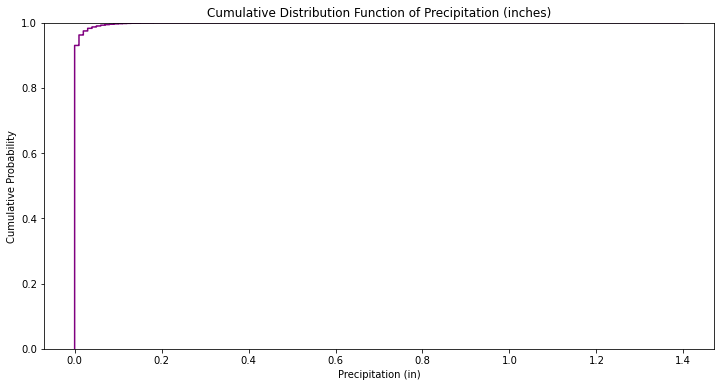

In [40]:
plt.figure(figsize=(12, 6))
sns.ecdfplot(les['Precip_in'], color='purple')
plt.title('Cumulative Distribution Function of Precipitation (inches)')
plt.xlabel('Precipitation (in)')
plt.ylabel('Cumulative Probability')
plt.show()

The CDF confirms that nearly all precipitation values are very small, with a sharp rise near zero. Only a tiny fraction of the data corresponds to higher precipitation levels, emphasizing the rarity of heavy rainfall.

<b>Now that we have done all the visualizations, what can we derive from this?</b>

Most of the precipitation data is near zero, with light rain being super common and heavy rain pretty rare. The boxplot shows a few outliers for heavy rain, and the CDF confirms almost all values are tiny. Overall, it’s mostly light or no rain with a few extreme cases.

### 9.2 Categorizing

We will categorize precipitation levels into four categories: 'No Rain', 'Less Rain', 'Medium Rain', and 'High Rain', using thresholds X1 = 0.01 and X2 = 0.04.

We'll create a function that checks the precipitation value (Precip_in) and assigns a category based on the thresholds:
- 0 = "No Rain"
- Between 0 and X1 = "Less Rain"
- Between X1 and X2 = "Medium Rain"
- Greater than X2 = "High Rain"


In [41]:
# Define thresholds
X1 = 0.01  # Less Rain threshold
X2 = 0.04  # Medium Rain threshold

# Function to categorize precipitation
def categorize_precipitation(precip, X1, X2):
    if precip == 0:
        return 'No Rain'
    elif 0 < precip <= X1:
        return 'Less Rain'
    elif X1 < precip <= X2:
        return 'Medium Rain'
    else:
        return 'High Rain'

# Apply the categorization
les['precipitation_category'] = les['Precip_in'].apply(lambda x: categorize_precipitation(x, X1, X2))

# Display category counts
print("\nPrecipitation Category Counts:")
print(les['precipitation_category'].value_counts())


Precipitation Category Counts:
No Rain        44534
Less Rain       1536
Medium Rain     1181
High Rain        631
Name: precipitation_category, dtype: int64


## 10. Basic Preprocessing and Encoding

Let's do some basic preprocessing before moving onto the the final goal of this notebook, the Sliding Window

We'll create a unified 'DateTime' column by combining 'Date_UTC' and 'Time_UTC' in both les and filtered_les. Then, we'll assign an 'image_index' to filtered_les and merge it into les, using -1 for observations without images. Finally, we'll sort the dataset by 'DateTime' and reset the index for clarity.

In [42]:
# Add 'DateTime' column to 'les' and 'filtered_les'
les['DateTime'] = les['Date_UTC'] + ' ' + les['Time_UTC']
filtered_les['DateTime'] = filtered_les['Date_UTC'] + ' ' + filtered_les['Time_UTC']

# Assign image indices to 'filtered_les'
filtered_les['image_index'] = filtered_les.index

# Merge 'filtered_les' into 'les' to add 'image_index'
les = les.merge(filtered_les[['DateTime', 'image_index']], on='DateTime', how='left')

# Fill NaN 'image_index' with -1 to indicate no image
les['image_index'] = les['image_index'].fillna(-1).astype(int)

# Ensure 'les' is sorted by 'DateTime'
les = les.sort_values('DateTime').reset_index(drop=True)

In [43]:
display(les[['DateTime', 'image_index', 'Precip_in', 'precipitation_category']].head(24))

,DateTime,image_index,Precip_in,precipitation_category
0,2006-10-01 00:00,-1,0.00,No Rain
1,2006-10-01 01:00,-1,0.00,No Rain
2,2006-10-01 02:00,-1,0.00,No Rain
3,2006-10-01 03:00,-1,0.00,No Rain
4,2006-10-01 04:00,-1,0.02,Medium Rain
5,2006-10-01 05:00,-1,0.01,Less Rain
6,2006-10-01 06:00,-1,0.00,No Rain
7,2006-10-01 07:00,-1,0.00,No Rain
8,2006-10-01 08:00,-1,0.00,No Rain
9,2006-10-01 09:00,-1,0.00,No Rain


Now, let's encode categorical precipitation levels into numerical values for machine learning

In [44]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
les['precipitation_category_encoded'] = label_encoder.fit_transform(les['precipitation_category'])

# Check label mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nLabel Mapping:", label_mapping)


Label Mapping: {'High Rain': 0, 'Less Rain': 1, 'Medium Rain': 2, 'No Rain': 3}


## 11. Sliding Window Creation for Meteorological and Image Data
<div style="text-align: center;">
    <img src="images/slidingwindow.jpg.webp" width="400" />



#### Overview
The sliding window approach is used to:
1. Aggregate meteorological and image data over time intervals of 24, 48, and 72 hours.
2. Prepare structured input data for training machine learning models.

Each sliding window includes:
- **Meteorological data**: Hourly observations for 14 features over the specified duration.
- **Satellite images**: Up to 8, 16, or 24 images (depending on the window size), with missing images replaced by zero-filled placeholders.
- **Target variable (`y`)**: Precipitation category at the end of the window.

## 11.1 Experiment: Prof's Sliding Window logic, using Keras API

Professor's announcement introduced a method using the Keras API to handle sliding windows, which we experimented with in this phase of the project. This experimentation aimed to explore the professor's approach and test its potential for generating data efficiently using sliding window logic. While this method provided valuable insights, we will not be incorporating it into our final model.

The reasoning behind this decision will be thoroughly explained during our final hybrid model presentation, where we’ll highlight why we opted for a different approach tailored to our goals and data requirements. That said, here is the data generation implemented using the professor’s logic, which was a useful step in understanding the problem and exploring alternative solutions.

Our code creates sliding windows for meteorological data by batching the sequences and aligning the targets based on the window size and prediction shift. We store the processed data in a structured format (`meteo_windows`) for easy access during further analysis or model training. This ensures that our data is efficiently segmented into fixed-length windows with corresponding targets, which is a crucial step for building time-series forecasting models.

In [ ]:
# Initialize dictionaries to store sliding windows
meteo_windows = {}
image_windows = {}
aligned_data = {}

# Step 5: Create Sliding Windows for Meteorological Data
for window_size, prediction_shift in zip(window_sizes, prediction_shifts):
    print(f"\nCreating sliding windows for {window_size}-hour meteorological data...")

    dataset_batched = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=X_meteo,
        targets=y_meteo[window_size + prediction_shift:],
        sequence_length=window_size,
        sequence_stride=window_size,
        sampling_rate=1,
        batch_size=64
    )

    X_full = []
    y_full = []
    for batch in dataset_batched:
        X_batch, y_batch = batch
        X_full.append(X_batch.numpy())
        y_full.append(y_batch.numpy())

    X_full = np.concatenate(X_full, axis=0)
    y_full = np.concatenate(y_full, axis=0)

    meteo_windows[window_size] = {'X': X_full, 'y': y_full}

    print(f"Sliding window shapes (Meteorological) - X: {X_full.shape}, y: {y_full.shape}")


Creating sliding windows for 24-hour meteorological data...
Sliding window shapes (Meteorological) - X: (1629, 24, 14), y: (1629,)

Creating sliding windows for 48-hour meteorological data...
Sliding window shapes (Meteorological) - X: (814, 48, 14), y: (814,)

Creating sliding windows for 72-hour meteorological data...
Sliding window shapes (Meteorological) - X: (542, 72, 14), y: (542,)


2024-12-06 01:56:47.971086: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-06 01:56:48.048577: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Now, we create a sliding window of the geospatial image data as well.

In [ ]:
# Step 6: Create Sliding Windows for Image Data
for window_size, num_images in image_window_sizes.items():
    print(f"\nCreating sliding windows for {window_size}-hour image data...")

    dataset_batched = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=X_images,
        targets=None,
        sequence_length=num_images,
        sequence_stride=num_images,
        sampling_rate=1,
        batch_size=64
    )

    X_full = []
    for batch in dataset_batched:
        X_full.append(batch.numpy())

    X_full = np.concatenate(X_full, axis=0)
    X_full = np.expand_dims(X_full, axis=-1) / 255

    image_windows[window_size] = {'X': X_full}

    print(f"Sliding window shapes (Images) - X: {X_full.shape}")


Creating sliding windows for 24-hour image data...
Sliding window shapes (Images) - X: (1629, 8, 64, 64, 1)

Creating sliding windows for 48-hour image data...


2024-12-06 01:56:48.213008: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Sliding window shapes (Images) - X: (814, 16, 64, 64, 1)

Creating sliding windows for 72-hour image data...
Sliding window shapes (Images) - X: (543, 24, 64, 64, 1)


Now, we align the meterological and image data in the sliding windows. This step ensures that our meteorological and image data are aligned and synchronized for each sliding window, avoiding inconsistencies during training. The aligned data is stored in aligned_data for easy access and is essential for combining multiple data sources effectively in our model.

In [ ]:
# Step 7: Align Meteorological and Image Data
for window_size in window_sizes:
    print(f"\nAligning data for {window_size}-hour window...")

    min_train_length = min(len(meteo_windows[window_size]['X']), len(image_windows[window_size]['X']))
    X_meteo_train = meteo_windows[window_size]['X'][:min_train_length]
    y_train = meteo_windows[window_size]['y'][:min_train_length]
    X_images_train = image_windows[window_size]['X'][:min_train_length]

    aligned_data[window_size] = {
        'X_meteo': X_meteo_train,
        'X_images': X_images_train,
        'y': y_train
    }

    print(f"Aligned data shapes - X_meteo: {X_meteo_train.shape}, X_images: {X_images_train.shape}, y: {y_train.shape}")


Aligning data for 24-hour window...
Aligned data shapes - X_meteo: (1629, 24, 14), X_images: (1629, 8, 64, 64, 1), y: (1629,)

Aligning data for 48-hour window...
Aligned data shapes - X_meteo: (814, 48, 14), X_images: (814, 16, 64, 64, 1), y: (814,)

Aligning data for 72-hour window...
Aligned data shapes - X_meteo: (542, 72, 14), X_images: (542, 24, 64, 64, 1), y: (542,)



Displaying a sample from the 24-hour window data...

Meteorological Data Sample:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,48.0,86.0,44.0,7.0,150.0,0.0,4100.0,4800.0,7000.0,10.0,984.0,1007.0,1006.8,0.00
1,48.0,86.0,44.0,8.0,150.0,0.0,6000.0,0.0,0.0,10.0,983.7,1006.5,1006.4,0.00
2,48.0,86.0,44.0,6.0,0.0,0.0,5500.0,11000.0,0.0,10.0,982.7,1005.7,1005.4,0.00
3,48.0,86.0,44.0,8.0,150.0,0.0,6000.0,0.0,0.0,10.0,982.0,1005.1,1004.7,0.00
4,48.0,89.0,45.0,5.0,0.0,0.0,2200.0,3500.0,0.0,8.0,982.0,1004.9,1004.7,0.02
5,48.0,89.0,45.0,6.0,0.0,0.0,2700.0,5500.0,7500.0,10.0,981.7,1004.6,1004.4,0.01
6,42.0,95.0,41.0,0.0,0.0,0.0,4600.0,0.0,0.0,8.0,991.7,1014.8,1014.6,0.00
7,43.0,96.0,42.0,0.0,0.0,0.0,3900.0,0.0,0.0,10.0,992.3,1015.6,1015.2,0.00
8,48.0,92.0,46.0,0.0,0.0,0.0,3600.0,0.0,0.0,10.0,993.0,1016.3,1015.9,0.00
9,55.0,59.0,41.0,11.0,300.0,0.0,3600.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00



Label (y): 3

Image Data Sample:


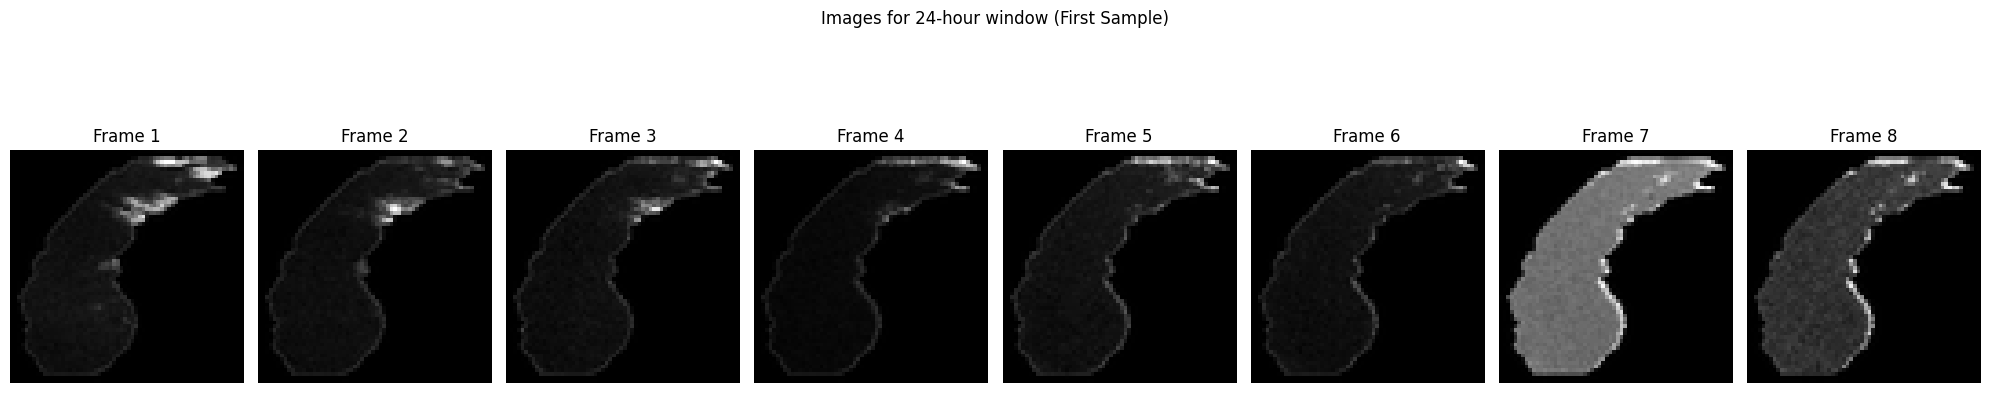

In [ ]:
# Step 8: Display a Sample from the Aligned Data
window_size = 24  # Select a window size to display
if window_size in aligned_data:
    print(f"\nDisplaying a sample from the {window_size}-hour window data...")

    X_meteo_sample = aligned_data[window_size]['X_meteo'][0]
    X_images_sample = aligned_data[window_size]['X_images'][0]
    y_sample = aligned_data[window_size]['y'][0]

    print("\nMeteorological Data Sample:")
    display(pd.DataFrame(X_meteo_sample, columns=meteo_features))

    print(f"\nLabel (y): {y_sample}")

    print("\nImage Data Sample:")
    fig, axes = plt.subplots(1, X_images_sample.shape[0], figsize=(20, 5))
    plt.suptitle(f"Images for {window_size}-hour window (First Sample)")

    for i, ax in enumerate(axes.flat):
        ax.imshow(X_images_sample[i, :, :, 0], cmap='gray')
        ax.axis('off')
        ax.set_title(f"Frame {i + 1}")

    plt.tight_layout()
    plt.show()
else:
    print(f"Window size {window_size} not found in aligned_data.")

In [ ]:
import pickle

for window_size, data in aligned_data.items():
    with open(f"aligned_data_{window_size}.pkl", "wb") as f:
        pickle.dump(data, f)
    print(f"Saved aligned data for {window_size}-hour window.")

Saved aligned data for 24-hour window.
Saved aligned data for 48-hour window.
Saved aligned data for 72-hour window.


The reason we will not be using this sliding window logic for our main hybrid model is that it creates significant issues with the validation dataset. When using this logic, the validation dataset becomes highly imbalanced, and in some cases, entire categories are completely missing. This imbalance makes it challenging to properly evaluate the model, as it cannot be tested on all target classes equally.

Attempts to balance the validation set only make matters worse, as the steps required to address the imbalance drastically reduce the dataset size. In some cases, the reduction is so severe that the model is left without enough data to generalize effectively, leading to poor performance and unreliable results. This makes the sliding window logic incompatible with this dataset, as it fails to provide a balanced and representative validation set necessary for meaningful training and evaluation.

While this approach has been valuable as an experiment to understand and test different methods for handling time-series data, it will not be used in our main hybrid model. We’ll instead focus on an approach that better suits the characteristics of our dataset. That said, we will still demonstrate this sliding window logic as part of our experimentation in the final hybrid model presentation to show its limitations and the lessons we’ve learned from it.

## 11.2 Final-Sliding Window

<b>What are Window Sizes?</b> 

In our project, the window sizes represent the duration of past meteorological data (in hours) used as input to make predictions. For example:
- A 24-hour window size means we use meteorological data from the last 24 hours as input.
- Similarly, a 48-hour window size uses the previous 48 hours, and a 72-hour window size uses the last 72 hours of data.

<b> What are Prediction Shifts? </b>

In our case, prediction shifts define how far into the future we are predicting, relative to the end of the input window. For example:
- A 24-hour prediction shift for a 24-hour window means we predict the precipitation category for the day immediately following the input window.
- A 48-hour prediction shift for a 48-hour window predicts precipitation for the second day after the input window.
- Similarly, a 72-hour prediction shift predicts for the next-to-next-to-next day after a 72-hour input window.

In [45]:
from tqdm import tqdm
import numpy as np

# Define window sizes and corresponding number of images
window_sizes = [24, 48, 72]  # in hours
images_per_window_dict = {24: 8, 48: 16, 72: 24}

# Define the prediction shift for each window size
prediction_shifts = {24: 24, 48: 48, 72: 72}

# window_sizes = [24]  # in hours
# images_per_window_dict = {24: 8}

# # Define the prediction shift for each window size
# prediction_shifts = {24: 24}

# Define meteorological features to include
meteo_features = [
    'Temp_F', 'RH_pct', 'Dewpt_F', 'Wind_Spd_mph',
    'Wind_Direction_deg', 'Peak_Wind_Gust_mph',
    'Low_Cloud_Ht_ft', 'Med_Cloud_Ht_ft',
    'High_Cloud_Ht_ft', 'Visibility_mi',
    'Atm_Press_hPa', 'Sea_Lev_Press_hPa',
    'Altimeter_hPa', 'Precip_in'
]

In [46]:
# Dictionary to store processed data
data_windows = {window_size: {'X_meteo': [], 'X_images': [], 'y': [], 'timestamps': []} for window_size in window_sizes}

We are processing meteorological and image data to create structured datasets for predicting future precipitation categories. Here's how we approach :
- Processing New Data:
    If the data isn’t available from our timestamping, we create sliding windows by extracting weather data and associated images for specific time periods. We filter images within a valid time range, pad missing data with placeholders, and trim any extra information to ensure uniformity.
- Defining Predictions:
    For each window, we identify the future weather condition (precipitation category) we aim to predict based on the input data.
- Saving Results:
    We save the processed weather data, images, targets, and timestamps in an organized format so we can reuse them for future modeling without reprocessing.

In [47]:
import os
import pickle
import numpy as np
from tqdm import tqdm

# Directory to store preprocessed data
data_dir = "preprocessed_data_corrected_final"
os.makedirs(data_dir, exist_ok=True)

# Dictionary to hold filepaths for processed data, including timestamps
data_files = {
    window_size: {
        'X_meteo': os.path.join(data_dir, f"X_meteo_{window_size}.pkl"),
        'X_images': os.path.join(data_dir, f"X_images_{window_size}.pkl"),
        'y': os.path.join(data_dir, f"y_{window_size}.pkl"),
        'timestamps': os.path.join(data_dir, f"timestamps_{window_size}.pkl"),  # Add timestamps
    } for window_size in window_sizes
}


# Dictionary to store processed data
data_windows = {window_size: {'X_meteo': [], 'X_images': [], 'y': [], 'timestamps': []} for window_size in window_sizes}

for window_size in window_sizes:
    print(f"\nProcessing data for window size: {window_size} hours")
    
    # Prediction shift for the current window size
    prediction_shift = prediction_shifts[window_size]
    
    # Check if all files exist for this window size
    if all(os.path.exists(data_files[window_size][key]) for key in ['X_meteo', 'X_images', 'y']):
        print(f"Data exists for window size: {window_size}. Loading...")
        
        # Load preprocessed data
        with open(data_files[window_size]['X_meteo'], 'rb') as f:
            data_windows[window_size]['X_meteo'] = pickle.load(f)
        with open(data_files[window_size]['X_images'], 'rb') as f:
            data_windows[window_size]['X_images'] = pickle.load(f)
        with open(data_files[window_size]['y'], 'rb') as f:
            data_windows[window_size]['y'] = pickle.load(f)
        with open(data_files[window_size]['timestamps'], 'rb') as f:  # Load timestamps
            data_windows[window_size]['timestamps'] = pickle.load(f)
        
        print(f"Loaded data for window size {window_size}: "
              f"X_meteo shape {np.array(data_windows[window_size]['X_meteo']).shape}, "
              f"X_images shape {np.array(data_windows[window_size]['X_images']).shape}, "
              f"y shape {np.array(data_windows[window_size]['y']).shape}")
    else:
        print(f"Data does not exist for window size: {window_size}. Creating...")
        
        # Process the data
        for i in tqdm(range(len(les) - window_size - prediction_shift)):
            window_start = i
            window_end = i + window_size  # Exclusive

            # Extract meteorological data
            meteo_window = les.iloc[window_start:window_end][meteo_features].values
            data_windows[window_size]['X_meteo'].append(meteo_window)

            # Extract timestamps and images within 14:00 to 21:00 UTC
            valid_images = []
            valid_timestamps = []

            # Process only timestamps and images in the current sliding window
            for row in les.iloc[window_start:window_end].itertuples():
                hour = int(row.DateTime.split(" ")[1][:2])  # Extract hour
                if 14 <= hour <= 21 and row.image_index != -1:  # Valid image time
                    valid_images.append(images[row.image_index])
                    valid_timestamps.append(row.DateTime)

            # Handle padding or truncation for images
            max_images = images_per_window_dict[window_size]
            if len(valid_images) < max_images:
                # Add placeholders if fewer valid images
                valid_images.extend([np.zeros((64, 64), dtype=np.uint8)] * (max_images - len(valid_images)))
                valid_timestamps.extend(["No Image"] * (max_images - len(valid_timestamps)))
            else:
                # Truncate to max_images
                valid_images = valid_images[:max_images]
                valid_timestamps = valid_timestamps[:max_images]

            # Add images and timestamps to the window data
            data_windows[window_size]['X_images'].append(np.array(valid_images).flatten())
            data_windows[window_size]['timestamps'].append(valid_timestamps)

            # Define target
            target_index = window_end + prediction_shift
            if target_index < len(les):
                target = les.iloc[target_index]['precipitation_category_encoded']
                data_windows[window_size]['y'].append(target)

        # Convert lists to numpy arrays
        data_windows[window_size]['X_meteo'] = np.array(data_windows[window_size]['X_meteo'])
        data_windows[window_size]['X_images'] = np.array(data_windows[window_size]['X_images'])
        data_windows[window_size]['y'] = np.array(data_windows[window_size]['y'])
        data_windows[window_size]['timestamps'] = np.array(data_windows[window_size]['timestamps'])
        
        print(f"Processed data for {window_size}: "
              f"X_meteo shape {data_windows[window_size]['X_meteo'].shape}, "
              f"X_images shape {data_windows[window_size]['X_images'].shape}, "
              f"y shape {data_windows[window_size]['y'].shape}")
        
        # Save processed data, including timestamps
        with open(data_files[window_size]['X_meteo'], 'wb') as f:
            pickle.dump(data_windows[window_size]['X_meteo'], f)
        with open(data_files[window_size]['X_images'], 'wb') as f:
            pickle.dump(data_windows[window_size]['X_images'], f)
        with open(data_files[window_size]['y'], 'wb') as f:
            pickle.dump(data_windows[window_size]['y'], f)
        with open(data_files[window_size]['timestamps'], 'wb') as f:  # Save timestamps
            pickle.dump(data_windows[window_size]['timestamps'], f)


print("Processing complete.")


Processing data for window size: 24 hours
Data exists for window size: 24. Loading...
Loaded data for window size 24: X_meteo shape (47834, 24, 14), X_images shape (47834, 32768), y shape (47834,)

Processing data for window size: 48 hours
Data exists for window size: 48. Loading...
Loaded data for window size 48: X_meteo shape (47786, 48, 14), X_images shape (47786, 65536), y shape (47786,)

Processing data for window size: 72 hours
Data exists for window size: 72. Loading...
Loaded data for window size 72: X_meteo shape (47738, 72, 14), X_images shape (47738, 98304), y shape (47738,)
Processing complete.


In [48]:
print(f"Timestamps shape: {np.array(data_windows[24]['timestamps']).shape}")

Timestamps shape: (47834, 8)


In [49]:
print(f"Timestamps shape: {np.array(data_windows[48]['timestamps']).shape}")

Timestamps shape: (47786, 16)


In [50]:
print(f"Timestamps shape: {np.array(data_windows[72]['timestamps']).shape}")

Timestamps shape: (47738, 24)


### 11.3 Visualizing Sliding Window Samples

Now, we that we have finished building the sliding window, let us visualize a few samples, to ensure that they out logic worked.

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def display_sliding_window_samples(data_windows, window_size, num_samples=24):
    """
    Display sliding window samples including meteorological data, associated images with timestamps, and window timeframe.

    Args:
        data_windows (dict): Contains 'X_meteo', 'X_images', 'timestamps', and 'y' for each window size.
        window_size (int): Size of the sliding window (24, 48, or 72 hours).
        num_samples (int): Number of sliding window samples to display.
    """
    # Extract relevant data for the given window size
    X_meteo = np.array(data_windows[window_size]['X_meteo'])
    X_images = np.array(data_windows[window_size]['X_images']).reshape(-1, images_per_window_dict[window_size], 64, 64)
    y = np.array(data_windows[window_size]['y'])
    timestamps = np.array(data_windows[window_size]['timestamps'])

    # Feature column names for meteorological data
    meteo_columns = [
        'Temp_F', 'RH_pct', 'Dewpt_F', 'Wind_Spd_mph', 'Wind_Direction_deg',
        'Peak_Wind_Gust_mph', 'Low_Cloud_Ht_ft', 'Med_Cloud_Ht_ft',
        'High_Cloud_Ht_ft', 'Visibility_mi', 'Atm_Press_hPa',
        'Sea_Lev_Press_hPa', 'Altimeter_hPa', 'Precip_in'
    ]

    # Display the selected number of samples
    for i in range(min(num_samples, len(X_meteo))):
        print(f"Sample {i + 1} (Window Size: {window_size} hours)")
        print(f"Timeframe: {timestamps[i][0]} to {timestamps[i][-1]}")
        print("--------------------------------------------------")

        # Display meteorological data
        print("Meteorological Data:")
        display(pd.DataFrame(X_meteo[i], columns=meteo_columns))
        print(f"Target (y): {y[i]}")

        # Plot images with timestamps
        fig, axes = plt.subplots(1, X_images.shape[1], figsize=(20, 5))
        plt.suptitle(f"Images for Sample {i + 1} (Window {window_size} hours)")

        for j, (img, ts) in enumerate(zip(X_images[i], timestamps[i])):
            ax = axes[j]
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            ax.set_title(ts if ts != "No Image" else "Placeholder")

        plt.tight_layout()
        plt.show()

Sample 1 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,48.0,86.0,44.0,7.0,150.0,0.0,4100.0,4800.0,7000.0,10.0,984.0,1007.0,1006.8,0.00
1,48.0,86.0,44.0,8.0,150.0,0.0,6000.0,0.0,0.0,10.0,983.7,1006.5,1006.4,0.00
2,48.0,86.0,44.0,6.0,0.0,0.0,5500.0,11000.0,0.0,10.0,982.7,1005.7,1005.4,0.00
3,48.0,86.0,44.0,8.0,150.0,0.0,6000.0,0.0,0.0,10.0,982.0,1005.1,1004.7,0.00
4,48.0,89.0,45.0,5.0,0.0,0.0,2200.0,3500.0,0.0,8.0,982.0,1004.9,1004.7,0.02
5,48.0,89.0,45.0,6.0,0.0,0.0,2700.0,5500.0,7500.0,10.0,981.7,1004.6,1004.4,0.01
6,42.0,95.0,41.0,0.0,0.0,0.0,4600.0,0.0,0.0,8.0,991.7,1014.8,1014.6,0.00
7,43.0,96.0,42.0,0.0,0.0,0.0,3900.0,0.0,0.0,10.0,992.3,1015.6,1015.2,0.00
8,48.0,92.0,46.0,0.0,0.0,0.0,3600.0,0.0,0.0,10.0,993.0,1016.3,1015.9,0.00
9,55.0,59.0,41.0,11.0,300.0,0.0,3600.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00


Target (y): 3


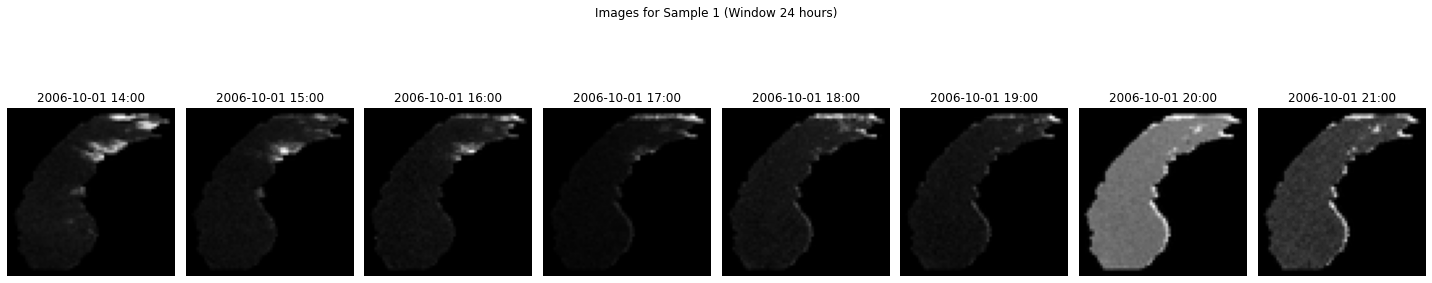

Sample 2 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,48.0,86.0,44.0,8.0,150.0,0.0,6000.0,0.0,0.0,10.0,983.7,1006.5,1006.4,0.00
1,48.0,86.0,44.0,6.0,0.0,0.0,5500.0,11000.0,0.0,10.0,982.7,1005.7,1005.4,0.00
2,48.0,86.0,44.0,8.0,150.0,0.0,6000.0,0.0,0.0,10.0,982.0,1005.1,1004.7,0.00
3,48.0,89.0,45.0,5.0,0.0,0.0,2200.0,3500.0,0.0,8.0,982.0,1004.9,1004.7,0.02
4,48.0,89.0,45.0,6.0,0.0,0.0,2700.0,5500.0,7500.0,10.0,981.7,1004.6,1004.4,0.01
5,42.0,95.0,41.0,0.0,0.0,0.0,4600.0,0.0,0.0,8.0,991.7,1014.8,1014.6,0.00
6,43.0,96.0,42.0,0.0,0.0,0.0,3900.0,0.0,0.0,10.0,992.3,1015.6,1015.2,0.00
7,48.0,92.0,46.0,0.0,0.0,0.0,3600.0,0.0,0.0,10.0,993.0,1016.3,1015.9,0.00
8,55.0,59.0,41.0,11.0,300.0,0.0,3600.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
9,55.0,61.0,42.0,10.0,300.0,0.0,3600.0,0.0,0.0,10.0,994.3,1017.5,1017.3,0.00


Target (y): 3


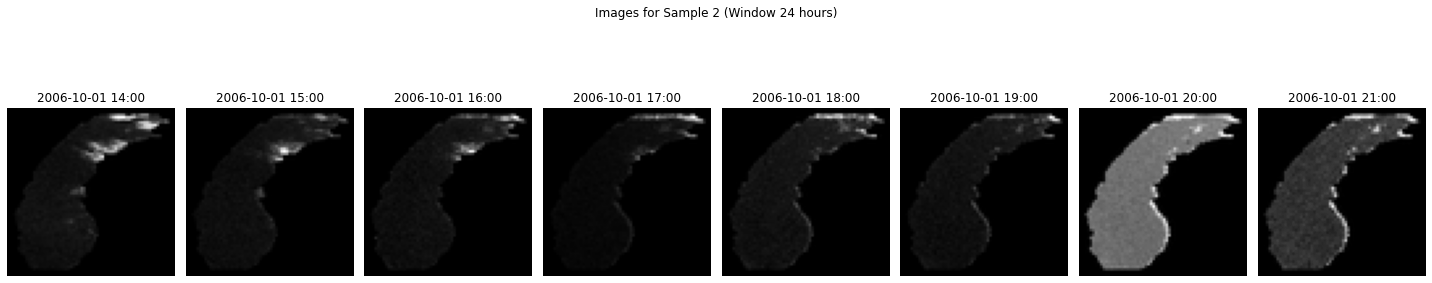

Sample 3 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,48.0,86.0,44.0,6.0,0.0,0.0,5500.0,11000.0,0.0,10.0,982.7,1005.7,1005.4,0.00
1,48.0,86.0,44.0,8.0,150.0,0.0,6000.0,0.0,0.0,10.0,982.0,1005.1,1004.7,0.00
2,48.0,89.0,45.0,5.0,0.0,0.0,2200.0,3500.0,0.0,8.0,982.0,1004.9,1004.7,0.02
3,48.0,89.0,45.0,6.0,0.0,0.0,2700.0,5500.0,7500.0,10.0,981.7,1004.6,1004.4,0.01
4,42.0,95.0,41.0,0.0,0.0,0.0,4600.0,0.0,0.0,8.0,991.7,1014.8,1014.6,0.00
5,43.0,96.0,42.0,0.0,0.0,0.0,3900.0,0.0,0.0,10.0,992.3,1015.6,1015.2,0.00
6,48.0,92.0,46.0,0.0,0.0,0.0,3600.0,0.0,0.0,10.0,993.0,1016.3,1015.9,0.00
7,55.0,59.0,41.0,11.0,300.0,0.0,3600.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
8,55.0,61.0,42.0,10.0,300.0,0.0,3600.0,0.0,0.0,10.0,994.3,1017.5,1017.3,0.00
9,58.0,55.0,42.0,8.0,290.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.0,1017.9,0.00


Target (y): 3


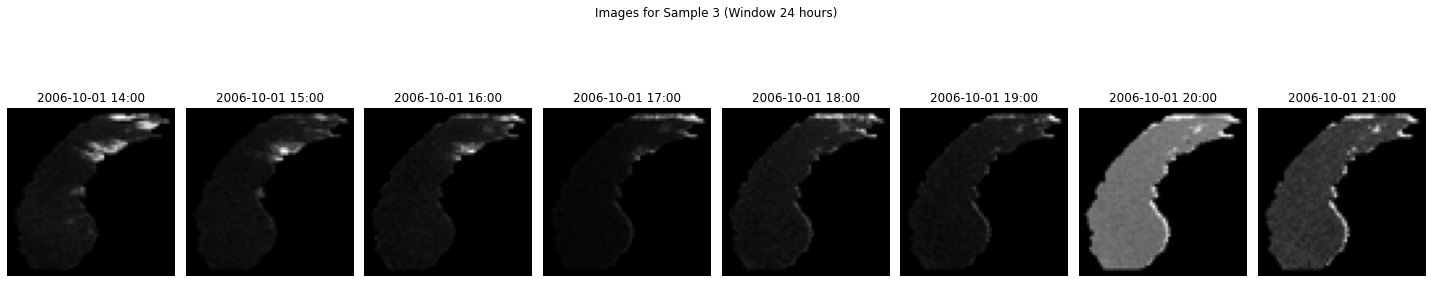

Sample 4 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,48.0,86.0,44.0,8.0,150.0,0.0,6000.0,0.0,0.0,10.0,982.0,1005.1,1004.7,0.00
1,48.0,89.0,45.0,5.0,0.0,0.0,2200.0,3500.0,0.0,8.0,982.0,1004.9,1004.7,0.02
2,48.0,89.0,45.0,6.0,0.0,0.0,2700.0,5500.0,7500.0,10.0,981.7,1004.6,1004.4,0.01
3,42.0,95.0,41.0,0.0,0.0,0.0,4600.0,0.0,0.0,8.0,991.7,1014.8,1014.6,0.00
4,43.0,96.0,42.0,0.0,0.0,0.0,3900.0,0.0,0.0,10.0,992.3,1015.6,1015.2,0.00
5,48.0,92.0,46.0,0.0,0.0,0.0,3600.0,0.0,0.0,10.0,993.0,1016.3,1015.9,0.00
6,55.0,59.0,41.0,11.0,300.0,0.0,3600.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
7,55.0,61.0,42.0,10.0,300.0,0.0,3600.0,0.0,0.0,10.0,994.3,1017.5,1017.3,0.00
8,58.0,55.0,42.0,8.0,290.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.0,1017.9,0.00
9,56.0,59.0,42.0,10.0,260.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00


Target (y): 3


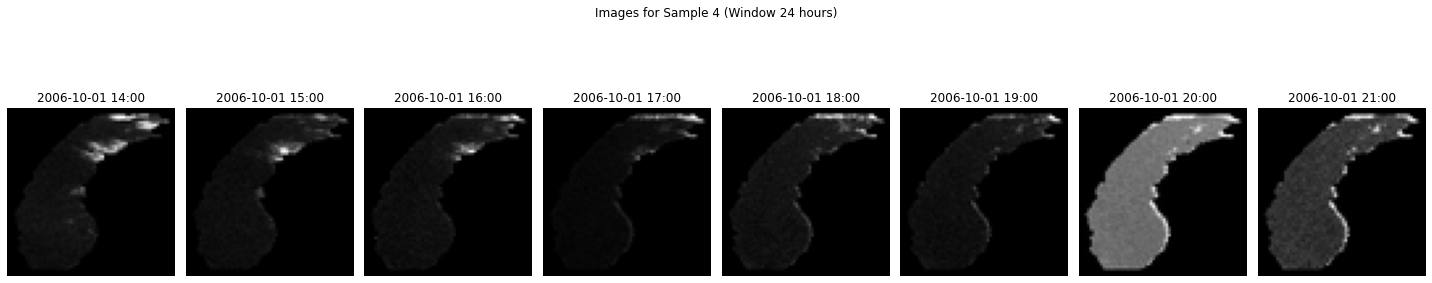

Sample 5 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,48.0,89.0,45.0,5.0,0.0,0.0,2200.0,3500.0,0.0,8.0,982.0,1004.9,1004.7,0.02
1,48.0,89.0,45.0,6.0,0.0,0.0,2700.0,5500.0,7500.0,10.0,981.7,1004.6,1004.4,0.01
2,42.0,95.0,41.0,0.0,0.0,0.0,4600.0,0.0,0.0,8.0,991.7,1014.8,1014.6,0.00
3,43.0,96.0,42.0,0.0,0.0,0.0,3900.0,0.0,0.0,10.0,992.3,1015.6,1015.2,0.00
4,48.0,92.0,46.0,0.0,0.0,0.0,3600.0,0.0,0.0,10.0,993.0,1016.3,1015.9,0.00
5,55.0,59.0,41.0,11.0,300.0,0.0,3600.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
6,55.0,61.0,42.0,10.0,300.0,0.0,3600.0,0.0,0.0,10.0,994.3,1017.5,1017.3,0.00
7,58.0,55.0,42.0,8.0,290.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.0,1017.9,0.00
8,56.0,59.0,42.0,10.0,260.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
9,60.0,53.0,43.0,9.0,300.0,0.0,3800.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00


Target (y): 1


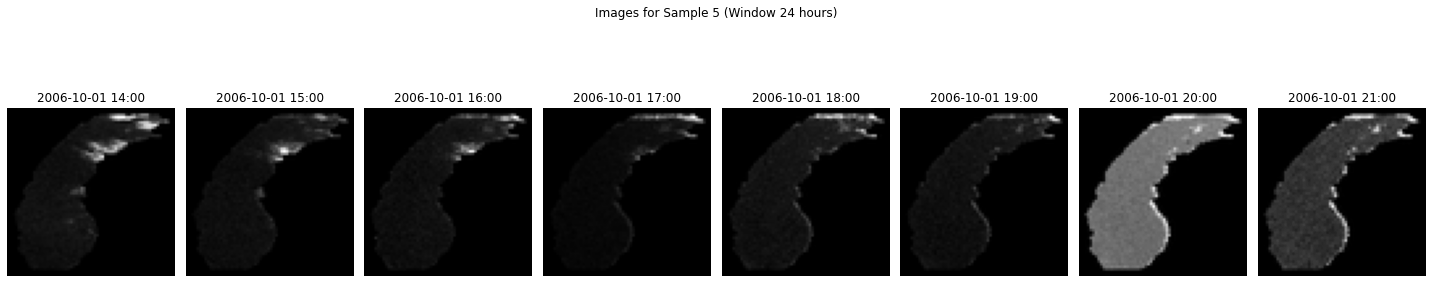

Sample 6 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,48.0,89.0,45.0,6.0,0.0,0.0,2700.0,5500.0,7500.0,10.0,981.7,1004.6,1004.4,0.01
1,42.0,95.0,41.0,0.0,0.0,0.0,4600.0,0.0,0.0,8.0,991.7,1014.8,1014.6,0.00
2,43.0,96.0,42.0,0.0,0.0,0.0,3900.0,0.0,0.0,10.0,992.3,1015.6,1015.2,0.00
3,48.0,92.0,46.0,0.0,0.0,0.0,3600.0,0.0,0.0,10.0,993.0,1016.3,1015.9,0.00
4,55.0,59.0,41.0,11.0,300.0,0.0,3600.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
5,55.0,61.0,42.0,10.0,300.0,0.0,3600.0,0.0,0.0,10.0,994.3,1017.5,1017.3,0.00
6,58.0,55.0,42.0,8.0,290.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.0,1017.9,0.00
7,56.0,59.0,42.0,10.0,260.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
8,60.0,53.0,43.0,9.0,300.0,0.0,3800.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
9,60.0,49.0,41.0,10.0,270.0,0.0,3600.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00


Target (y): 3


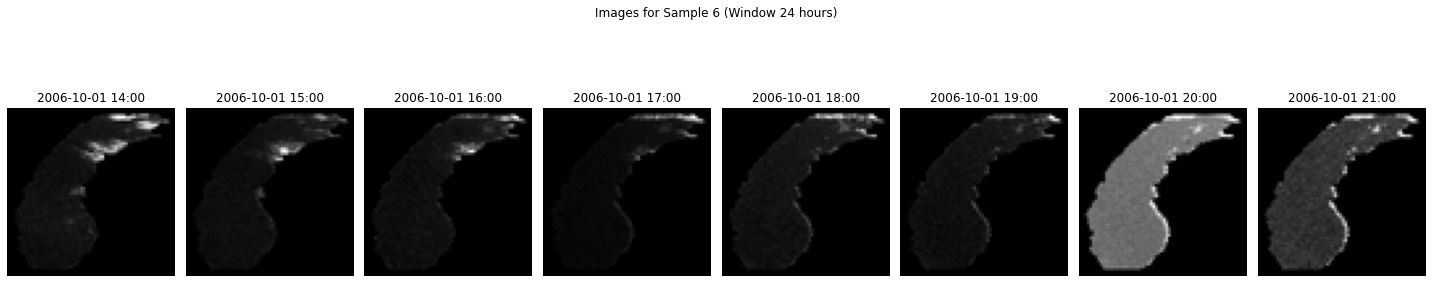

Sample 7 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,42.0,95.0,41.0,0.0,0.0,0.0,4600.0,0.0,0.0,8.0,991.7,1014.8,1014.6,0.00
1,43.0,96.0,42.0,0.0,0.0,0.0,3900.0,0.0,0.0,10.0,992.3,1015.6,1015.2,0.00
2,48.0,92.0,46.0,0.0,0.0,0.0,3600.0,0.0,0.0,10.0,993.0,1016.3,1015.9,0.00
3,55.0,59.0,41.0,11.0,300.0,0.0,3600.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
4,55.0,61.0,42.0,10.0,300.0,0.0,3600.0,0.0,0.0,10.0,994.3,1017.5,1017.3,0.00
5,58.0,55.0,42.0,8.0,290.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.0,1017.9,0.00
6,56.0,59.0,42.0,10.0,260.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
7,60.0,53.0,43.0,9.0,300.0,0.0,3800.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
8,60.0,49.0,41.0,10.0,270.0,0.0,3600.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
9,60.0,47.0,40.0,3.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.7,1017.6,0.00


Target (y): 3


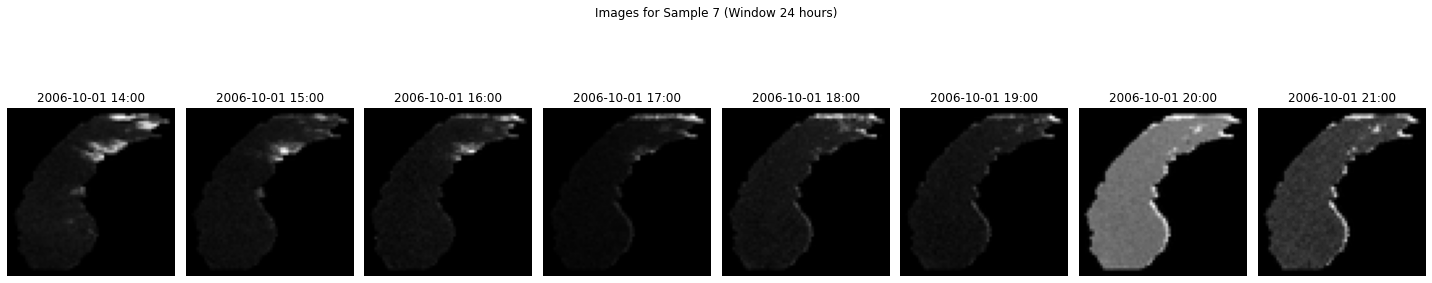

Sample 8 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,43.0,96.0,42.0,0.0,0.0,0.0,3900.0,0.0,0.0,10.0,992.3,1015.6,1015.2,0.00
1,48.0,92.0,46.0,0.0,0.0,0.0,3600.0,0.0,0.0,10.0,993.0,1016.3,1015.9,0.00
2,55.0,59.0,41.0,11.0,300.0,0.0,3600.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
3,55.0,61.0,42.0,10.0,300.0,0.0,3600.0,0.0,0.0,10.0,994.3,1017.5,1017.3,0.00
4,58.0,55.0,42.0,8.0,290.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.0,1017.9,0.00
5,56.0,59.0,42.0,10.0,260.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
6,60.0,53.0,43.0,9.0,300.0,0.0,3800.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
7,60.0,49.0,41.0,10.0,270.0,0.0,3600.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
8,60.0,47.0,40.0,3.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.7,1017.6,0.00
9,59.0,55.0,43.0,6.0,40.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00


Target (y): 3


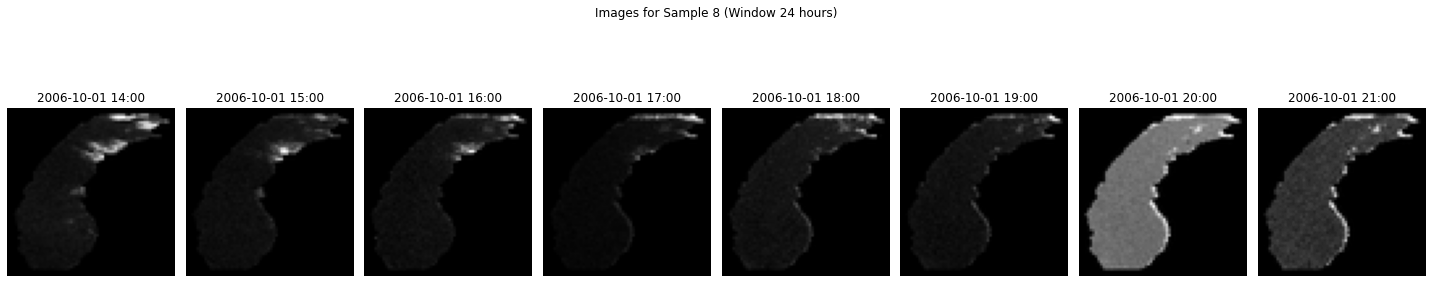

Sample 9 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,48.0,92.0,46.0,0.0,0.0,0.0,3600.0,0.0,0.0,10.0,993.0,1016.3,1015.9,0.00
1,55.0,59.0,41.0,11.0,300.0,0.0,3600.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
2,55.0,61.0,42.0,10.0,300.0,0.0,3600.0,0.0,0.0,10.0,994.3,1017.5,1017.3,0.00
3,58.0,55.0,42.0,8.0,290.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.0,1017.9,0.00
4,56.0,59.0,42.0,10.0,260.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
5,60.0,53.0,43.0,9.0,300.0,0.0,3800.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
6,60.0,49.0,41.0,10.0,270.0,0.0,3600.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
7,60.0,47.0,40.0,3.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.7,1017.6,0.00
8,59.0,55.0,43.0,6.0,40.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
9,55.0,71.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00


Target (y): 3


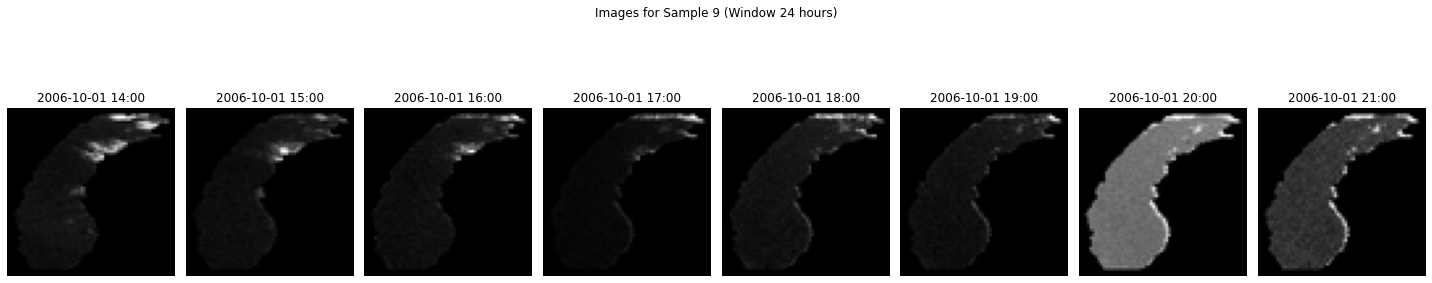

Sample 10 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,55.0,59.0,41.0,11.0,300.0,0.0,3600.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
1,55.0,61.0,42.0,10.0,300.0,0.0,3600.0,0.0,0.0,10.0,994.3,1017.5,1017.3,0.00
2,58.0,55.0,42.0,8.0,290.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.0,1017.9,0.00
3,56.0,59.0,42.0,10.0,260.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
4,60.0,53.0,43.0,9.0,300.0,0.0,3800.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
5,60.0,49.0,41.0,10.0,270.0,0.0,3600.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
6,60.0,47.0,40.0,3.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.7,1017.6,0.00
7,59.0,55.0,43.0,6.0,40.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
8,55.0,71.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
9,50.0,82.0,45.0,0.0,0.0,0.0,8000.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00


Target (y): 3


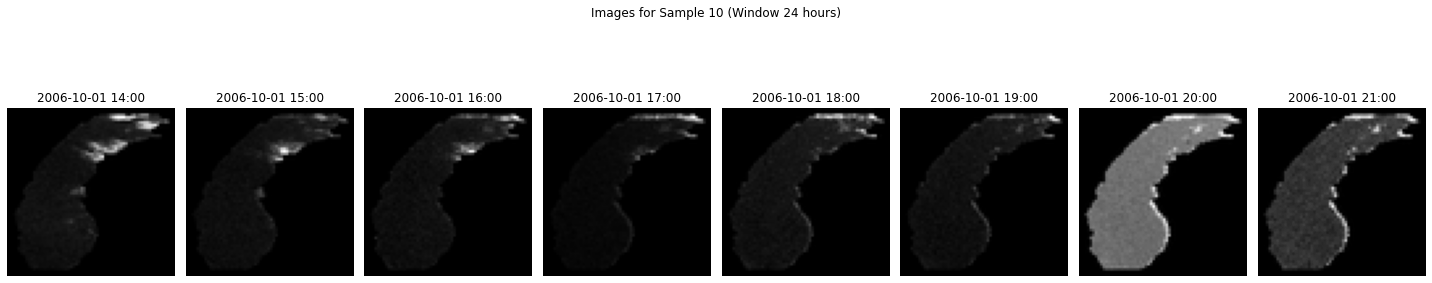

Sample 11 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,55.0,61.0,42.0,10.0,300.0,0.0,3600.0,0.0,0.0,10.0,994.3,1017.5,1017.3,0.00
1,58.0,55.0,42.0,8.0,290.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.0,1017.9,0.00
2,56.0,59.0,42.0,10.0,260.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
3,60.0,53.0,43.0,9.0,300.0,0.0,3800.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
4,60.0,49.0,41.0,10.0,270.0,0.0,3600.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
5,60.0,47.0,40.0,3.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.7,1017.6,0.00
6,59.0,55.0,43.0,6.0,40.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
7,55.0,71.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
8,50.0,82.0,45.0,0.0,0.0,0.0,8000.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
9,48.0,86.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00


Target (y): 3


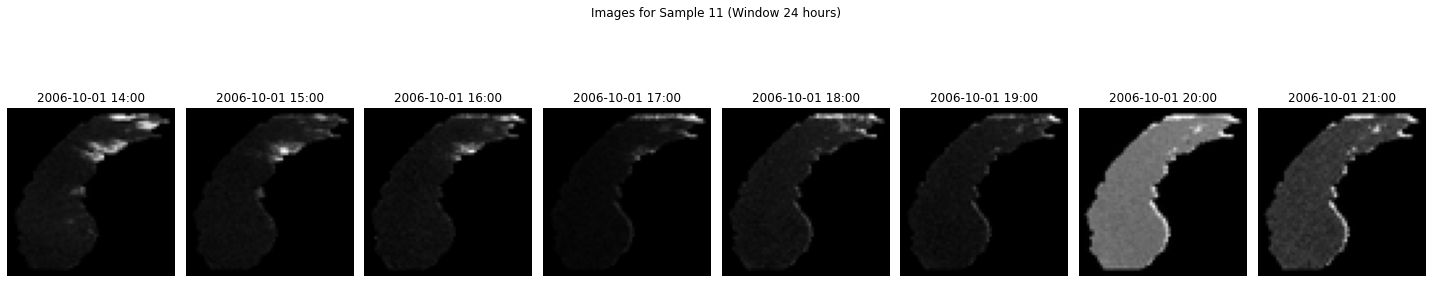

Sample 12 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,58.0,55.0,42.0,8.0,290.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.0,1017.9,0.00
1,56.0,59.0,42.0,10.0,260.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
2,60.0,53.0,43.0,9.0,300.0,0.0,3800.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
3,60.0,49.0,41.0,10.0,270.0,0.0,3600.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
4,60.0,47.0,40.0,3.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.7,1017.6,0.00
5,59.0,55.0,43.0,6.0,40.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
6,55.0,71.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
7,50.0,82.0,45.0,0.0,0.0,0.0,8000.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
8,48.0,86.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
9,48.0,86.0,44.0,3.0,160.0,0.0,12000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00


Target (y): 3


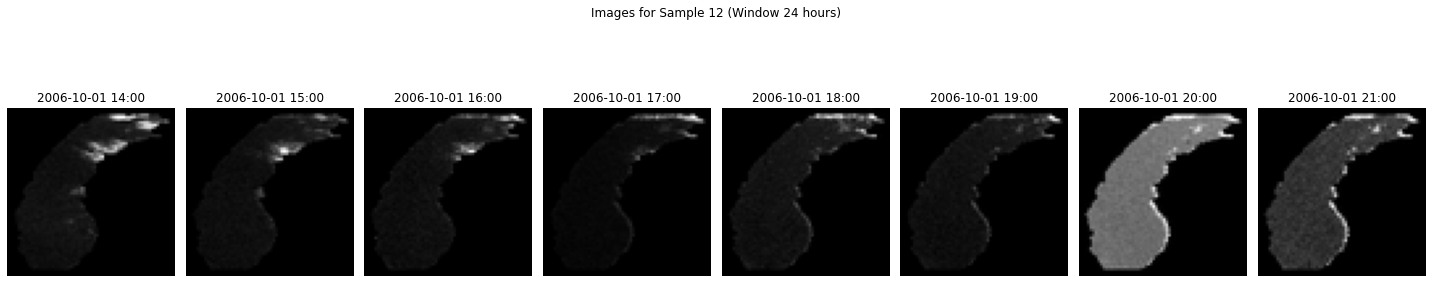

Sample 13 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,56.0,59.0,42.0,10.0,260.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
1,60.0,53.0,43.0,9.0,300.0,0.0,3800.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
2,60.0,49.0,41.0,10.0,270.0,0.0,3600.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
3,60.0,47.0,40.0,3.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.7,1017.6,0.00
4,59.0,55.0,43.0,6.0,40.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
5,55.0,71.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
6,50.0,82.0,45.0,0.0,0.0,0.0,8000.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
7,48.0,86.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
8,48.0,86.0,44.0,3.0,160.0,0.0,12000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
9,49.0,79.0,43.0,3.0,130.0,0.0,11000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00


Target (y): 3


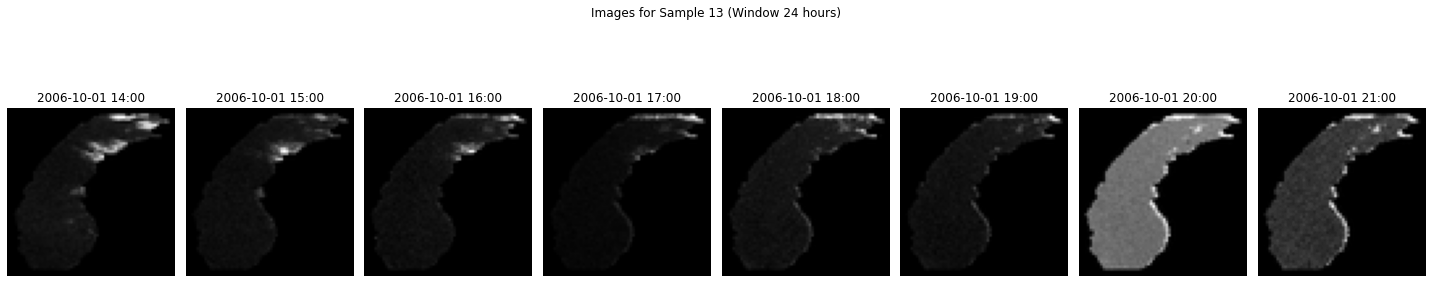

Sample 14 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,60.0,53.0,43.0,9.0,300.0,0.0,3800.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
1,60.0,49.0,41.0,10.0,270.0,0.0,3600.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
2,60.0,47.0,40.0,3.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.7,1017.6,0.00
3,59.0,55.0,43.0,6.0,40.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
4,55.0,71.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
5,50.0,82.0,45.0,0.0,0.0,0.0,8000.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
6,48.0,86.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
7,48.0,86.0,44.0,3.0,160.0,0.0,12000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
8,49.0,79.0,43.0,3.0,130.0,0.0,11000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
9,51.0,73.0,43.0,6.0,0.0,0.0,11000.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00


Target (y): 3


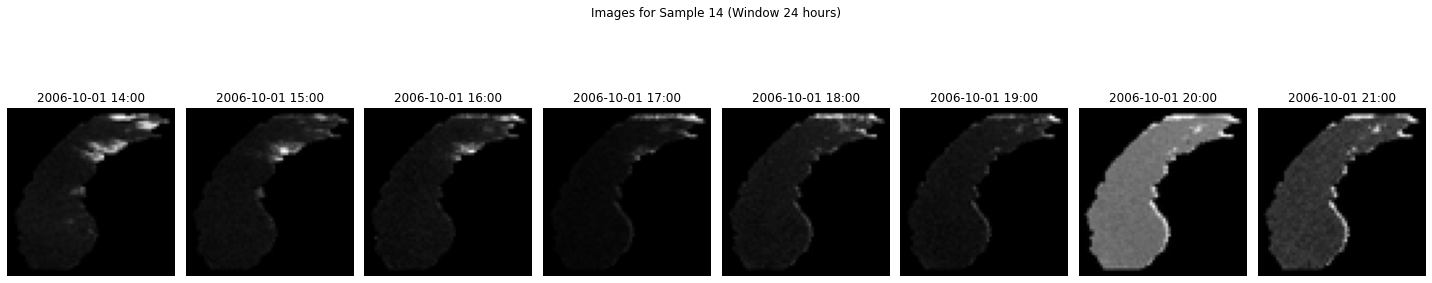

Sample 15 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,60.0,49.0,41.0,10.0,270.0,0.0,3600.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
1,60.0,47.0,40.0,3.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.7,1017.6,0.00
2,59.0,55.0,43.0,6.0,40.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
3,55.0,71.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
4,50.0,82.0,45.0,0.0,0.0,0.0,8000.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
5,48.0,86.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
6,48.0,86.0,44.0,3.0,160.0,0.0,12000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
7,49.0,79.0,43.0,3.0,130.0,0.0,11000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
8,51.0,73.0,43.0,6.0,0.0,0.0,11000.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
9,51.0,79.0,45.0,5.0,170.0,0.0,10000.0,0.0,0.0,10.0,994.0,1017.0,1016.9,0.00


Target (y): 3


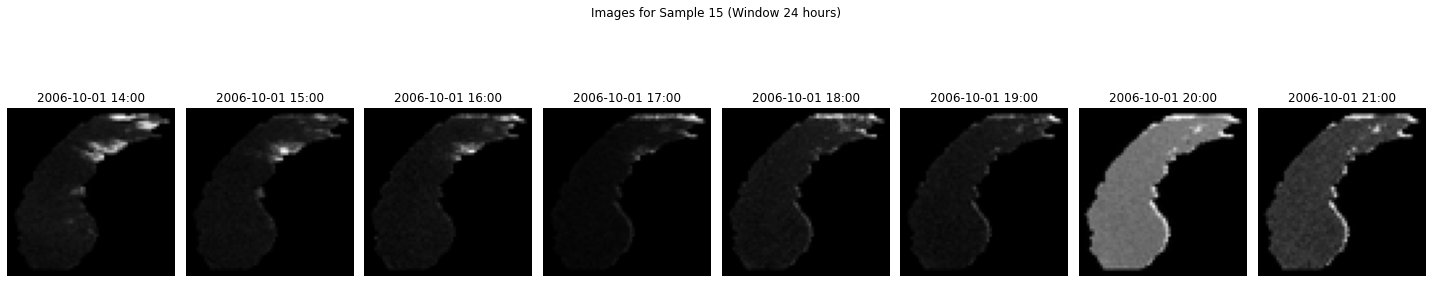

Sample 16 (Window Size: 24 hours)
Timeframe: 2006-10-01 15:00 to 2006-10-02 14:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,60.0,47.0,40.0,3.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.7,1017.6,0.00
1,59.0,55.0,43.0,6.0,40.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
2,55.0,71.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
3,50.0,82.0,45.0,0.0,0.0,0.0,8000.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
4,48.0,86.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
5,48.0,86.0,44.0,3.0,160.0,0.0,12000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
6,49.0,79.0,43.0,3.0,130.0,0.0,11000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
7,51.0,73.0,43.0,6.0,0.0,0.0,11000.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
8,51.0,79.0,45.0,5.0,170.0,0.0,10000.0,0.0,0.0,10.0,994.0,1017.0,1016.9,0.00
9,50.0,92.0,48.0,0.0,0.0,0.0,6500.0,0.0,0.0,9.0,987.3,1010.2,1010.2,0.01


Target (y): 3


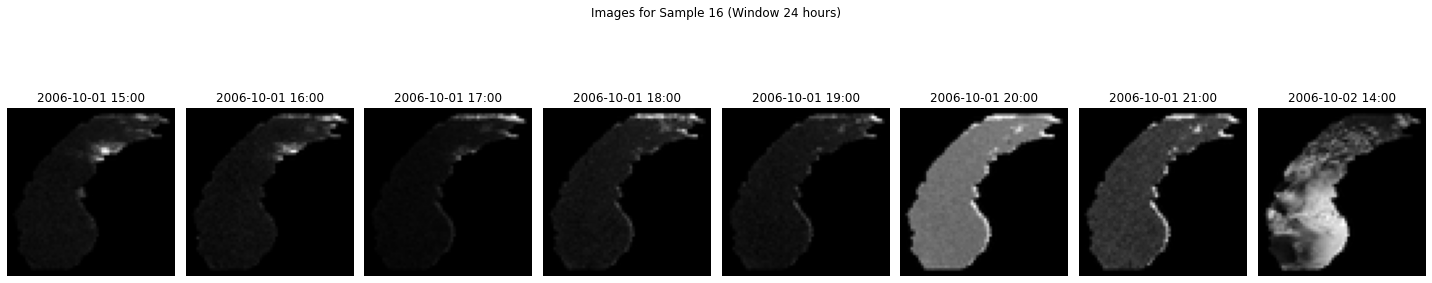

Sample 17 (Window Size: 24 hours)
Timeframe: 2006-10-01 16:00 to 2006-10-02 15:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,59.0,55.0,43.0,6.0,40.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
1,55.0,71.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
2,50.0,82.0,45.0,0.0,0.0,0.0,8000.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
3,48.0,86.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
4,48.0,86.0,44.0,3.0,160.0,0.0,12000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
5,49.0,79.0,43.0,3.0,130.0,0.0,11000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
6,51.0,73.0,43.0,6.0,0.0,0.0,11000.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
7,51.0,79.0,45.0,5.0,170.0,0.0,10000.0,0.0,0.0,10.0,994.0,1017.0,1016.9,0.00
8,50.0,92.0,48.0,0.0,0.0,0.0,6500.0,0.0,0.0,9.0,987.3,1010.2,1010.2,0.01
9,48.0,92.0,46.0,3.0,230.0,0.0,0.0,0.0,0.0,9.0,988.0,1010.8,1010.8,0.00


Target (y): 3


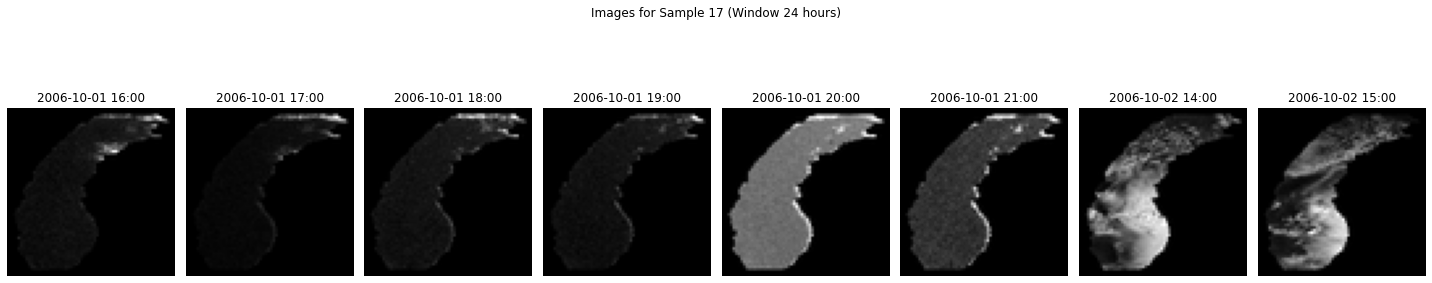

Sample 18 (Window Size: 24 hours)
Timeframe: 2006-10-01 17:00 to 2006-10-02 16:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,55.0,71.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
1,50.0,82.0,45.0,0.0,0.0,0.0,8000.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
2,48.0,86.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
3,48.0,86.0,44.0,3.0,160.0,0.0,12000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
4,49.0,79.0,43.0,3.0,130.0,0.0,11000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
5,51.0,73.0,43.0,6.0,0.0,0.0,11000.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
6,51.0,79.0,45.0,5.0,170.0,0.0,10000.0,0.0,0.0,10.0,994.0,1017.0,1016.9,0.00
7,50.0,92.0,48.0,0.0,0.0,0.0,6500.0,0.0,0.0,9.0,987.3,1010.2,1010.2,0.01
8,48.0,92.0,46.0,3.0,230.0,0.0,0.0,0.0,0.0,9.0,988.0,1010.8,1010.8,0.00
9,45.0,100.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,988.3,0.0,1011.2,0.00


Target (y): 3


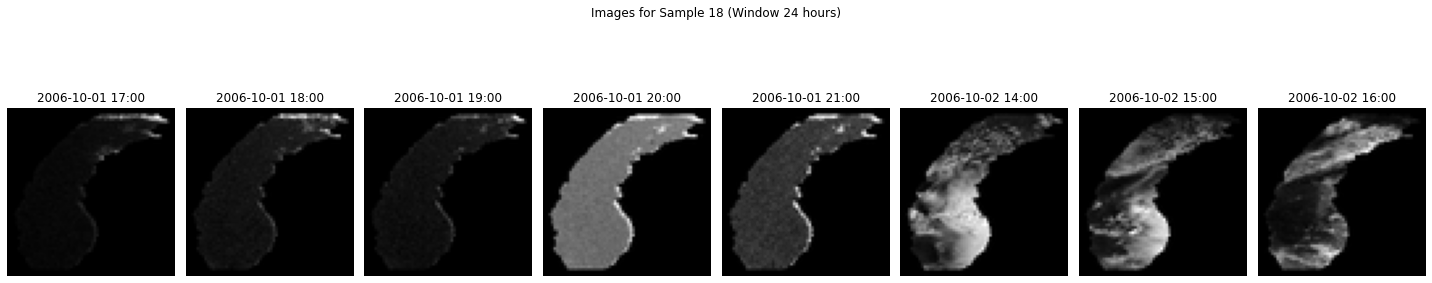

Sample 19 (Window Size: 24 hours)
Timeframe: 2006-10-01 18:00 to 2006-10-02 17:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,50.0,82.0,45.0,0.0,0.0,0.0,8000.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
1,48.0,86.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
2,48.0,86.0,44.0,3.0,160.0,0.0,12000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
3,49.0,79.0,43.0,3.0,130.0,0.0,11000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
4,51.0,73.0,43.0,6.0,0.0,0.0,11000.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
5,51.0,79.0,45.0,5.0,170.0,0.0,10000.0,0.0,0.0,10.0,994.0,1017.0,1016.9,0.00
6,50.0,92.0,48.0,0.0,0.0,0.0,6500.0,0.0,0.0,9.0,987.3,1010.2,1010.2,0.01
7,48.0,92.0,46.0,3.0,230.0,0.0,0.0,0.0,0.0,9.0,988.0,1010.8,1010.8,0.00
8,45.0,100.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,988.3,0.0,1011.2,0.00
9,43.0,100.0,43.0,0.0,0.0,0.0,4200.0,0.0,0.0,5.0,989.0,0.0,1011.9,0.00


Target (y): 3


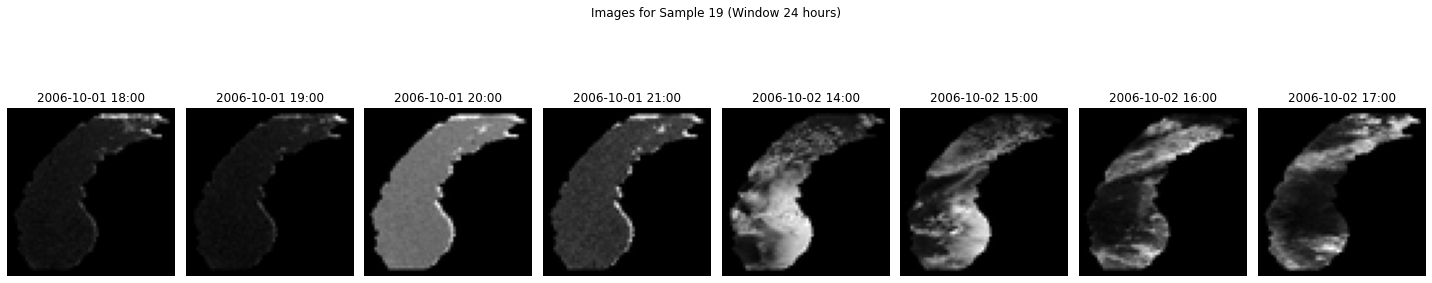

Sample 20 (Window Size: 24 hours)
Timeframe: 2006-10-01 19:00 to 2006-10-02 18:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,48.0,86.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
1,48.0,86.0,44.0,3.0,160.0,0.0,12000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
2,49.0,79.0,43.0,3.0,130.0,0.0,11000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
3,51.0,73.0,43.0,6.0,0.0,0.0,11000.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
4,51.0,79.0,45.0,5.0,170.0,0.0,10000.0,0.0,0.0,10.0,994.0,1017.0,1016.9,0.00
5,50.0,92.0,48.0,0.0,0.0,0.0,6500.0,0.0,0.0,9.0,987.3,1010.2,1010.2,0.01
6,48.0,92.0,46.0,3.0,230.0,0.0,0.0,0.0,0.0,9.0,988.0,1010.8,1010.8,0.00
7,45.0,100.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,988.3,0.0,1011.2,0.00
8,43.0,100.0,43.0,0.0,0.0,0.0,4200.0,0.0,0.0,5.0,989.0,0.0,1011.9,0.00
9,42.0,95.0,41.0,0.0,0.0,0.0,5000.0,0.0,0.0,2.0,989.7,1012.8,1012.5,0.00


Target (y): 3


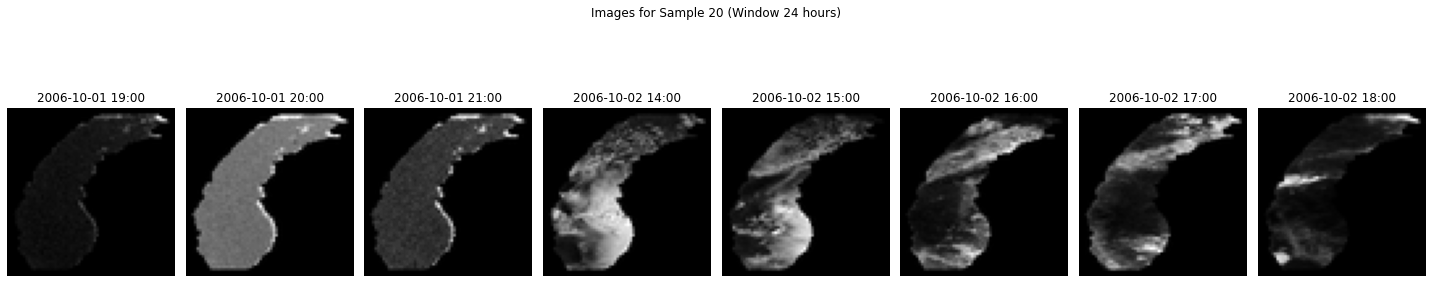

Sample 21 (Window Size: 24 hours)
Timeframe: 2006-10-01 20:00 to 2006-10-02 19:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,48.0,86.0,44.0,3.0,160.0,0.0,12000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
1,49.0,79.0,43.0,3.0,130.0,0.0,11000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
2,51.0,73.0,43.0,6.0,0.0,0.0,11000.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
3,51.0,79.0,45.0,5.0,170.0,0.0,10000.0,0.0,0.0,10.0,994.0,1017.0,1016.9,0.00
4,50.0,92.0,48.0,0.0,0.0,0.0,6500.0,0.0,0.0,9.0,987.3,1010.2,1010.2,0.01
5,48.0,92.0,46.0,3.0,230.0,0.0,0.0,0.0,0.0,9.0,988.0,1010.8,1010.8,0.00
6,45.0,100.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,988.3,0.0,1011.2,0.00
7,43.0,100.0,43.0,0.0,0.0,0.0,4200.0,0.0,0.0,5.0,989.0,0.0,1011.9,0.00
8,42.0,95.0,41.0,0.0,0.0,0.0,5000.0,0.0,0.0,2.0,989.7,1012.8,1012.5,0.00
9,41.0,95.0,40.0,0.0,0.0,0.0,4600.0,0.0,0.0,10.0,990.7,1013.6,1013.5,0.00


Target (y): 3


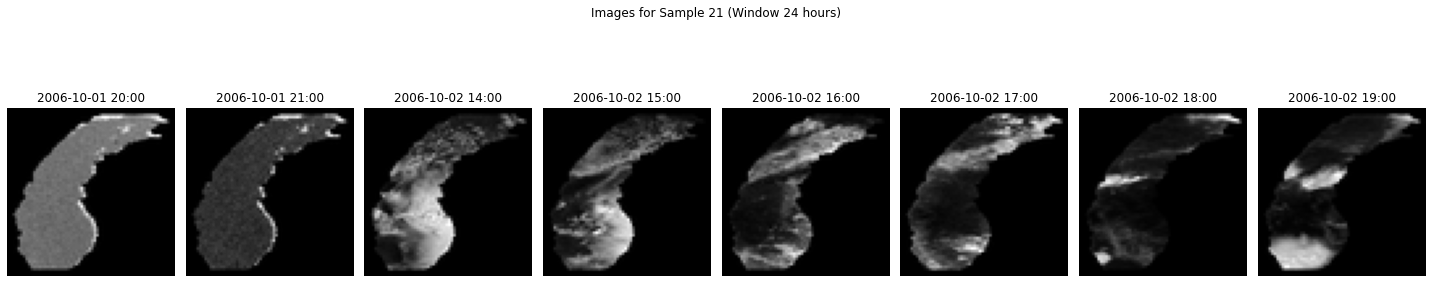

Sample 22 (Window Size: 24 hours)
Timeframe: 2006-10-01 21:00 to 2006-10-02 20:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,49.0,79.0,43.0,3.0,130.0,0.0,11000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
1,51.0,73.0,43.0,6.0,0.0,0.0,11000.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
2,51.0,79.0,45.0,5.0,170.0,0.0,10000.0,0.0,0.0,10.0,994.0,1017.0,1016.9,0.00
3,50.0,92.0,48.0,0.0,0.0,0.0,6500.0,0.0,0.0,9.0,987.3,1010.2,1010.2,0.01
4,48.0,92.0,46.0,3.0,230.0,0.0,0.0,0.0,0.0,9.0,988.0,1010.8,1010.8,0.00
5,45.0,100.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,988.3,0.0,1011.2,0.00
6,43.0,100.0,43.0,0.0,0.0,0.0,4200.0,0.0,0.0,5.0,989.0,0.0,1011.9,0.00
7,42.0,95.0,41.0,0.0,0.0,0.0,5000.0,0.0,0.0,2.0,989.7,1012.8,1012.5,0.00
8,41.0,95.0,40.0,0.0,0.0,0.0,4600.0,0.0,0.0,10.0,990.7,1013.6,1013.5,0.00
9,58.0,74.0,50.0,3.0,0.0,0.0,8500.0,0.0,0.0,10.0,990.7,1013.8,1013.5,0.00


Target (y): 3


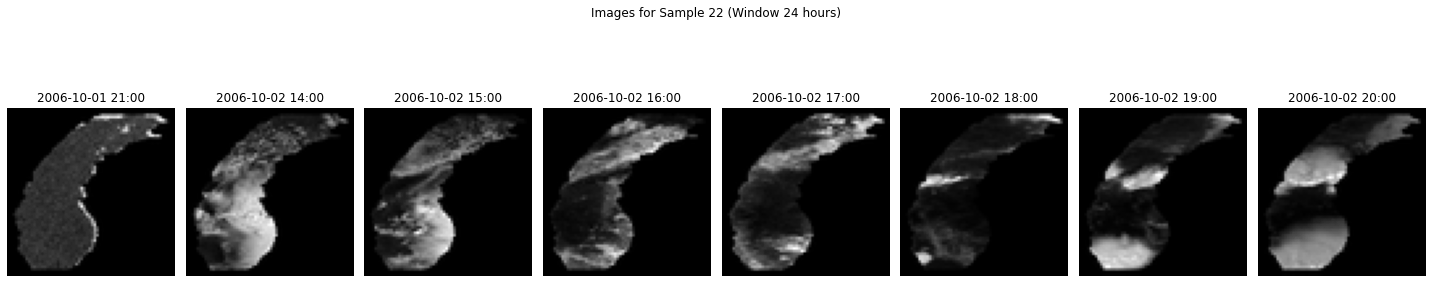

Sample 23 (Window Size: 24 hours)
Timeframe: 2006-10-02 14:00 to 2006-10-02 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,51.0,73.0,43.0,6.0,0.0,0.0,11000.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
1,51.0,79.0,45.0,5.0,170.0,0.0,10000.0,0.0,0.0,10.0,994.0,1017.0,1016.9,0.00
2,50.0,92.0,48.0,0.0,0.0,0.0,6500.0,0.0,0.0,9.0,987.3,1010.2,1010.2,0.01
3,48.0,92.0,46.0,3.0,230.0,0.0,0.0,0.0,0.0,9.0,988.0,1010.8,1010.8,0.00
4,45.0,100.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,988.3,0.0,1011.2,0.00
5,43.0,100.0,43.0,0.0,0.0,0.0,4200.0,0.0,0.0,5.0,989.0,0.0,1011.9,0.00
6,42.0,95.0,41.0,0.0,0.0,0.0,5000.0,0.0,0.0,2.0,989.7,1012.8,1012.5,0.00
7,41.0,95.0,40.0,0.0,0.0,0.0,4600.0,0.0,0.0,10.0,990.7,1013.6,1013.5,0.00
8,58.0,74.0,50.0,3.0,0.0,0.0,8500.0,0.0,0.0,10.0,990.7,1013.8,1013.5,0.00
9,64.0,67.0,53.0,7.0,0.0,0.0,7500.0,0.0,0.0,10.0,991.3,1014.3,1014.2,0.00


Target (y): 0


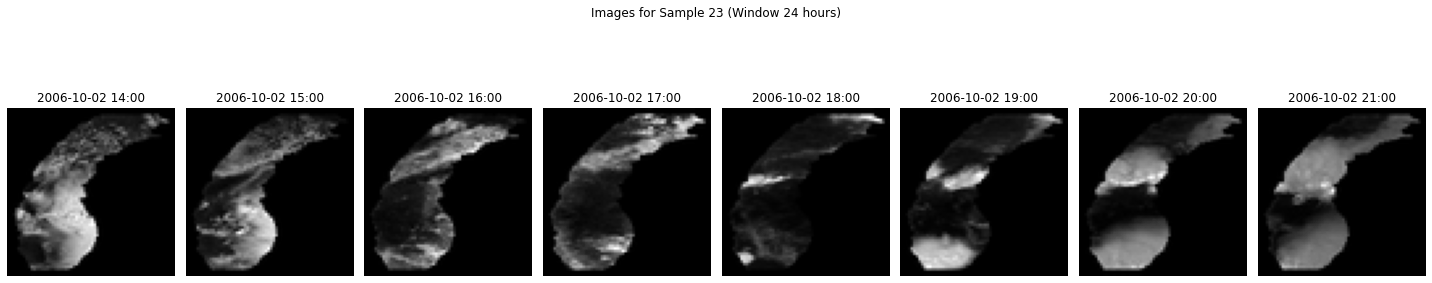

Sample 24 (Window Size: 24 hours)
Timeframe: 2006-10-02 14:00 to 2006-10-02 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,51.0,79.0,45.0,5.0,170.0,0.0,10000.0,0.0,0.0,10.0,994.0,1017.0,1016.9,0.00
1,50.0,92.0,48.0,0.0,0.0,0.0,6500.0,0.0,0.0,9.0,987.3,1010.2,1010.2,0.01
2,48.0,92.0,46.0,3.0,230.0,0.0,0.0,0.0,0.0,9.0,988.0,1010.8,1010.8,0.00
3,45.0,100.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,988.3,0.0,1011.2,0.00
4,43.0,100.0,43.0,0.0,0.0,0.0,4200.0,0.0,0.0,5.0,989.0,0.0,1011.9,0.00
5,42.0,95.0,41.0,0.0,0.0,0.0,5000.0,0.0,0.0,2.0,989.7,1012.8,1012.5,0.00
6,41.0,95.0,40.0,0.0,0.0,0.0,4600.0,0.0,0.0,10.0,990.7,1013.6,1013.5,0.00
7,58.0,74.0,50.0,3.0,0.0,0.0,8500.0,0.0,0.0,10.0,990.7,1013.8,1013.5,0.00
8,64.0,67.0,53.0,7.0,0.0,0.0,7500.0,0.0,0.0,10.0,991.3,1014.3,1014.2,0.00
9,66.0,65.0,54.0,8.0,170.0,0.0,8000.0,0.0,0.0,10.0,991.0,1013.9,1013.9,0.00


Target (y): 0


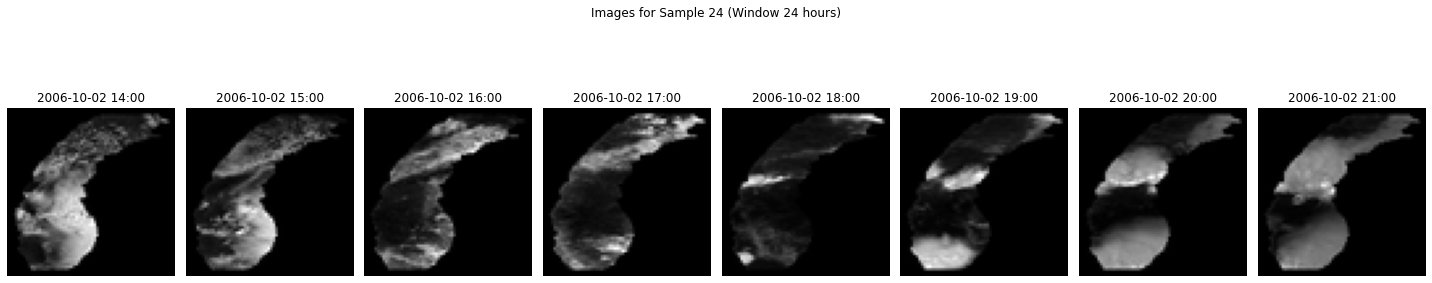

In [52]:
# Display the first 24 samples for a 24-hour window
display_sliding_window_samples(data_windows, window_size=24, num_samples=24)

## 12. Milestone 1, Part-2: Conclusion

Now, with everything we have done so far, we successfully completed all the requirements for Part 2 of Milestone 1. The data was cleaned, missing values handled, and columns renamed for clarity. We filtered the data to focus on relevant time ranges, categorized precipitation into four levels, and resized satellite images for consistency. Sliding windows were created to structure meteorological and image data over 24, 48, and 72 hours for predicting future precipitation. We also validated our work with visualizations to ensure accuracy. The dataset is now fully prepped and ready for modeling!



<div style="text-align: center;">
    <img src="images/DALL·E 2024-12-02 18.31.42 - A clean and simple digital image with the phrase 'We Are Done Here' prominently displayed. The design is straightforward with bold, modern typography .webp" width="400" />
    <img src="images/DALL·E 2024-12-02 18.33.06 - A clean and simple digital image with the phrase 'On to the Next One' prominently displayed. The design is straightforward with bold, modern typograph.webp" width="400" />